In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.dates import DateFormatter

import sys,time,datetime,copy,subprocess,itertools,pickle,warnings,json,gc,numbers

In [2]:
dataframe = []
for entry in os.scandir("./data"):
    if entry.is_file():
        df = pd.read_csv(entry.path,sep=" ",names=["date","time"])
        df['isopen'] = 1 if 'open' in entry.path else 0
        df['timestamp'] = pd.to_datetime(df['date']+' '+df['time'])
        df.drop(columns=['date','time'],inplace=True)
        df['N'] = df.index
        dataframe.append(df)
df = pd.concat(dataframe, ignore_index=True)
df.head()

,isopen,timestamp,N
0,0,2022-01-03 16:30:00.482218274,0
1,0,2022-01-03 16:30:00.532858460,1
2,0,2022-01-03 16:30:00.582860889,2
3,0,2022-01-03 16:30:01.085502073,3
4,0,2022-01-03 16:30:01.185507128,4


<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>


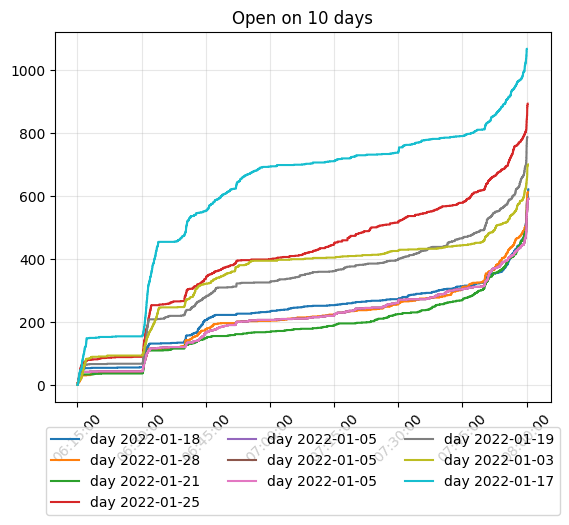

In [3]:
n = 10
jours = np.random.choice(df.timestamp.dt.date.unique(),n)
for jour in jours:
    tableau = df[df.timestamp.dt.date == jour]
    print(type(jour))
    tabopen = tableau[tableau.isopen == 1]
    times = tabopen.timestamp.dt.time
    plot_times = pd.to_datetime([f'1900-01-01 {t}' for t in times.astype(str)])

    plt.step(plot_times,y=tabopen.N,label=f"day {jour}")
    
    plt.title(f"Open on {n} days")
hh_mm = DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_formatter(hh_mm)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=min(3, n), frameon=True)
plt.show()

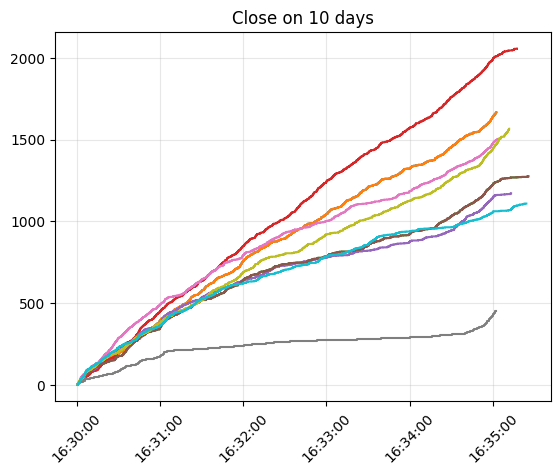

In [4]:
n = 10
jours = np.random.choice(df.timestamp.dt.date.unique(),n)
for jour in jours:
    tableau = df[df.timestamp.dt.date == jour]
    tabclose = tableau[tableau.isopen == 0]
    times = tabclose.timestamp.dt.time
    plot_times = pd.to_datetime([f'1900-01-01 {t}' for t in times.astype(str)])
    plt.step(plot_times,y=tabclose.N,label=f"day {jour}")
    
    plt.title(f"Close on {n} days")
hh_mm = DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_formatter(hh_mm)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.show()

In [5]:
import Hawkes as hk

In [6]:
t = np.sort(np.array([(x - tabclose.timestamp.iloc[0]).total_seconds() / 3600 for x in tabclose.timestamp]))
t[:5]

array([0.00000000e+00, 1.38894444e-05, 6.95005556e-05, 8.34155556e-05,
       9.73238889e-05])

In [7]:
model = hk.estimator()
model.set_kernel('exp')
model.set_baseline('const')
model.fit(t,[0,np.max(t)])
print("parameter:",model.parameter) # the estimated parameter values
print("branching ratio:",model.br) # the branching ratio
print("log-likelihood:",model.L) # the log-likelihood of the estimated parameter values
print("AIC:",model.AIC) # the AIC of the estimated parameter values


parameter: {'mu': 12327.78402895887, 'alpha': 2.5385762557333266e-05, 'beta': 0.00010066892268627801}
branching ratio: 2.5385762557333266e-05
log-likelihood: 9320.509214725282
AIC: -18635.018429450563


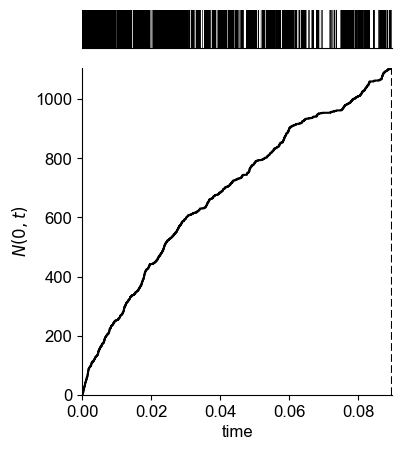

In [8]:
T_pred = model.predict(np.max(t[:len(t)]),100)
model.plot_N_pred()

In [9]:
def data_simulateur(param=model.parameter,maximum_t=max(t)):
    simulateur = hk.simulator()
    simulateur.set_kernel('exp').set_baseline('const').set_parameter(param)
    interval = [0,maximum_t]
    t_simul = simulateur.simulate(interval)
    N_simul = list(range(len(t_simul)))
    return t_simul,N_simul
t_simul,N_simul = data_simulateur()
#plt.step(t_simul,N_simul)


In [10]:
def estimateur(tableau):
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('exp').set_baseline("const")
    model.fit(t,[0,np.max(t)])
    return model,max(t)

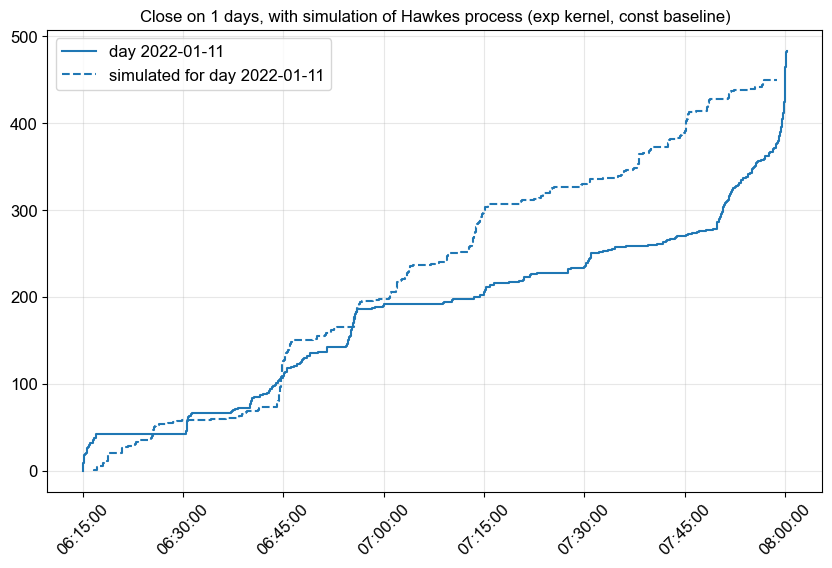

log-likelihood: 2702.53457041463
AIC: -5399.06914082926


In [11]:
n = 1
np.random.seed(42)
jours = np.random.choice(df.timestamp.dt.date.unique(),n)
colors = plt.cm.tab10(np.linspace(0, 1, n))  # Create a color palette
plt.figure(figsize=(10, 6))
for i, jour in enumerate(jours):
    tableau = df[df.timestamp.dt.date == jour]
    tabclose = tableau[tableau.isopen == 1]
    times = tabclose.timestamp.dt.time
    plot_times = pd.to_datetime([f'1900-01-01 {t}' for t in times.astype(str)])
    
    # Plot actual data with solid line and consistent color
    plt.step(plot_times, y=tabclose.N, label=f"day {jour}", 
             color=colors[i], linestyle='-')
    
    # Get simulated data
    model,max_t = estimateur(tabclose)
    t_simul, N_simul = data_simulateur(model.parameter,max_t)
    
    # Convert t_simul from hours to datetime objects with proper time offsets
    base_time = tabclose.timestamp.iloc[0]
    simul_datetimes = [base_time + pd.Timedelta(hours=t) for t in t_simul]
    
    # add new origin so they all start at the same day to show same hour
    simul_plot_times = pd.to_datetime([f'1900-01-01 {t.time()}' for t in simul_datetimes])
    
    # Plot simulated data with dashed line and same color as actual data
    plt.step(simul_plot_times, N_simul, label=f'simulated for day {jour}',
             color=colors[i], linestyle='--')
    
plt.title(f"Close on {n} days, with simulation of Hawkes process (exp kernel, const baseline)")
hh_mm = DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_formatter(hh_mm)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend()
plt.show()
print("log-likelihood:",model.L) # the log-likelihood of the estimated parameter values
print("AIC:",model.AIC) # the AIC of the estimated parameter values


📅 Traitement du jour 2022-01-03
✅ OK — L = 5824.98

📅 Traitement du jour 2022-01-04
✅ OK — L = 4344.70

📅 Traitement du jour 2022-01-05
✅ OK — L = 7291.23

📅 Traitement du jour 2022-01-06
✅ OK — L = 12336.13

📅 Traitement du jour 2022-01-07
✅ OK — L = 9119.71

📅 Traitement du jour 2022-01-10
⚠️ Overflow détecté : overflow encountered in exp. Skip.

📅 Traitement du jour 2022-01-11
✅ OK — L = 6617.45

📅 Traitement du jour 2022-01-12
⚠️ Overflow détecté : overflow encountered in exp. Skip.

📅 Traitement du jour 2022-01-13
✅ OK — L = 9956.19

📅 Traitement du jour 2022-01-14
✅ OK — L = 9320.51

📅 Traitement du jour 2022-01-17
⚠️ Overflow détecté : overflow encountered in exp. Skip.

📅 Traitement du jour 2022-01-18
⚠️ Overflow détecté : overflow encountered in exp. Skip.

📅 Traitement du jour 2022-01-19
✅ OK — L = 9715.91

📅 Traitement du jour 2022-01-20
✅ OK — L = 10899.94

📅 Traitement du jour 2022-01-21
⚠️ Overflow détecté : overflow encountered in exp. Skip.

📅 Traitement du jour 2022-0

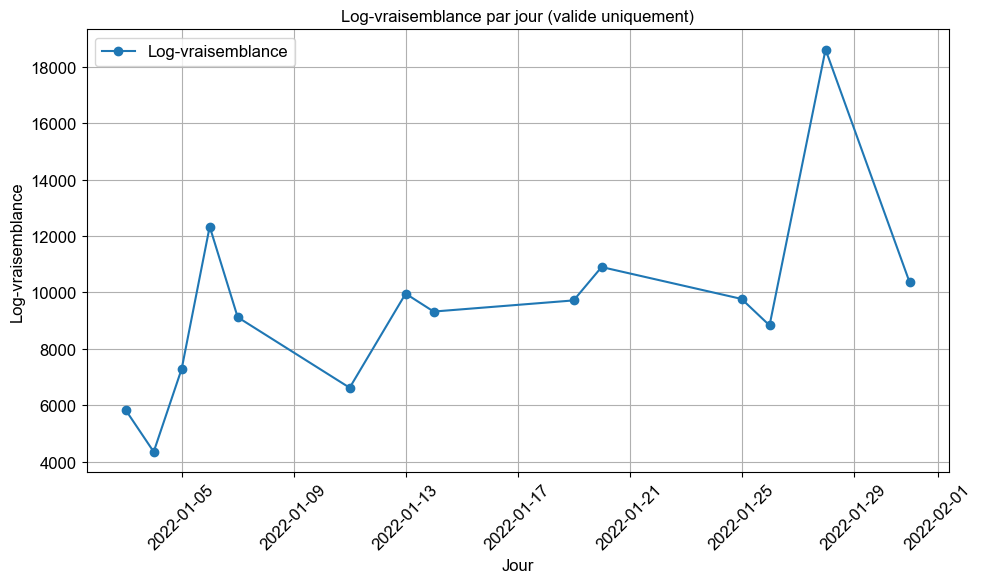


🚫 Journées avec problème (fit ou simulation) :
 - 2022-01-10
 - 2022-01-12
 - 2022-01-17
 - 2022-01-18
 - 2022-01-21
 - 2022-01-24
 - 2022-01-27


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
import warnings

# Convertir tous les RuntimeWarning (ex: overflow) en erreurs bloquantes
warnings.filterwarnings("error", category=RuntimeWarning)

# === Fonctions ===

def data_simulateur_pow(param, maximum_t):
    simulateur = hk.simulator()
    simulateur.set_kernel('pow').set_baseline('const').set_parameter(param)
    interval = [0, maximum_t]
    t_simul = simulateur.simulate(interval)
    N_simul = list(range(len(t_simul)))
    return t_simul, N_simul

def estimateur_pow(tableau):
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('pow').set_baseline('const')
    model.fit(t, [0, np.max(t)])
    return model, np.max(t)

# === Boucle sur toutes les journées ===

jours = sorted(df.timestamp.dt.date.unique())
log_likelihoods = []
days_valid = []
days_failed = []

for jour in jours:
    print(f"\n📅 Traitement du jour {jour}")

    tableau = df[df.timestamp.dt.date == jour]
    tabclose = tableau[tableau.isopen == 0]

    if len(tabclose) == 0:
        print(f"⚠️ Aucun événement. Skip.")
        days_failed.append(jour)
        continue

    try:
        model, max_t = estimateur_pow(tabclose)

        # Vérification overflow ou valeurs absurdes
        if not np.isfinite(model.L) or not np.isfinite(list(model.parameter.values())).all():
            print(f"⚠️ Paramètres ou log-vraisemblance invalides. Skip.")
            days_failed.append(jour)
            continue

        # Simulation aussi sous protection
        try:
            _ = data_simulateur_pow(model.parameter, max_t)
        except Exception as e:
            print(f"❌ Échec simulation : {e}")
            days_failed.append(jour)
            continue

        log_likelihoods.append(model.L)
        days_valid.append(jour)
        print(f"✅ OK — L = {model.L:.2f}")

    except RuntimeWarning as w:
        print(f"⚠️ Overflow détecté : {w}. Skip.")
        days_failed.append(jour)
        continue
    except Exception as e:
        print(f"❌ Erreur estimation : {e}")
        days_failed.append(jour)
        continue

# === Affichage des résultats ===

# Graphe log-vraisemblance
plt.figure(figsize=(10, 6))
plt.plot(days_valid, log_likelihoods, marker='o', linestyle='-', label="Log-vraisemblance")
plt.title("Log-vraisemblance par jour (valide uniquement)")
plt.xlabel("Jour")
plt.ylabel("Log-vraisemblance")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# Affichage des jours échoués
print("\n🚫 Journées avec problème (fit ou simulation) :")
for j in days_failed:
    print(f" - {j}")


In [66]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
import warnings

# Convertir tous les RuntimeWarning (ex: overflow) en erreurs bloquantes
warnings.filterwarnings("error", category=RuntimeWarning)

# === Fonctions ===


def estimateur_plinear(tableau):
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('pow').set_baseline('loglinear',num_basis=20)  # Utiliser la baseline affine par morceaux
    model.fit(t, [0, np.max(t)])
    return model, np.max(t)

# === Boucle sur toutes les journées ===

jours = sorted(df.timestamp.dt.date.unique())
log_likelihoods_plinear = []
days_valid_plinear = []
days_failed_plinear = []

for jour in jours:
    print(f"\n📅 Traitement du jour {jour}")

    tableau = df[df.timestamp.dt.date == jour]
    tabclose = tableau[tableau.isopen == 0]

    if len(tabclose) == 0:
        print(f"⚠️ Aucun événement. Skip.")
        days_failed_plinear.append(jour)
        continue

    try:
        model, max_t = estimateur_plinear(tabclose)  # Utiliser le modèle avec baseline affine par morceaux


        log_likelihoods_plinear.append(model.L)
        days_valid_plinear.append(jour)
        print(f"✅ OK — L = {model.L:.2f}")

    except RuntimeWarning as w:
        print(f"⚠️ Overflow détecté : {w}. Skip.")
        days_failed_plinear.append(jour)
        continue
    except Exception as e:
        print(f"❌ Erreur estimation : {e}")
        days_failed_plinear.append(jour)
        continue

# === Affichage des résultats ===

# Graphe log-vraisemblance pour baseline affine par morceaux (plinear)
plt.figure(figsize=(10, 6))
plt.plot(days_valid_plinear, log_likelihoods_plinear, marker='o', linestyle='-', label="Log-vraisemblance (plinear)")
plt.title("Log-vraisemblance par jour pour la baseline affine par morceaux (plinear)")
plt.xlabel("Jour")
plt.ylabel("Log-vraisemblance")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# Affichage des jours échoués pour baseline affine par morceaux (plinear)
print("\n🚫 Journées avec problème (fit ou simulation) pour plinear :")
for j in days_failed_plinear:
    print(f" - {j}")



📅 Traitement du jour 2022-01-03
✅ OK — L = 5992.18

📅 Traitement du jour 2022-01-04
✅ OK — L = 4485.96

📅 Traitement du jour 2022-01-05
✅ OK — L = 7564.77

📅 Traitement du jour 2022-01-06
⚠️ Overflow détecté : overflow encountered in exp. Skip.

📅 Traitement du jour 2022-01-07
⚠️ Overflow détecté : overflow encountered in exp. Skip.

📅 Traitement du jour 2022-01-10
✅ OK — L = 13886.18

📅 Traitement du jour 2022-01-11
✅ OK — L = 6802.83

📅 Traitement du jour 2022-01-12
✅ OK — L = 13370.82

📅 Traitement du jour 2022-01-13
✅ OK — L = 10140.04

📅 Traitement du jour 2022-01-14
⚠️ Overflow détecté : overflow encountered in exp. Skip.

📅 Traitement du jour 2022-01-17
⚠️ Overflow détecté : overflow encountered in exp. Skip.

📅 Traitement du jour 2022-01-18
⚠️ Overflow détecté : overflow encountered in exp. Skip.

📅 Traitement du jour 2022-01-19
✅ OK — L = 9835.61

📅 Traitement du jour 2022-01-20
✅ OK — L = 11070.70

📅 Traitement du jour 2022-01-21
✅ OK — L = 14864.51

📅 Traitement du jour 202

KeyboardInterrupt: 

2022-01-11
Model parameters: {'mu': 56.039340793851174, 'alpha': 0.8031717908265573, 'beta': 600.9984786711128}
log-likelihood: 2702.53457041463
AIC: -5399.06914082926


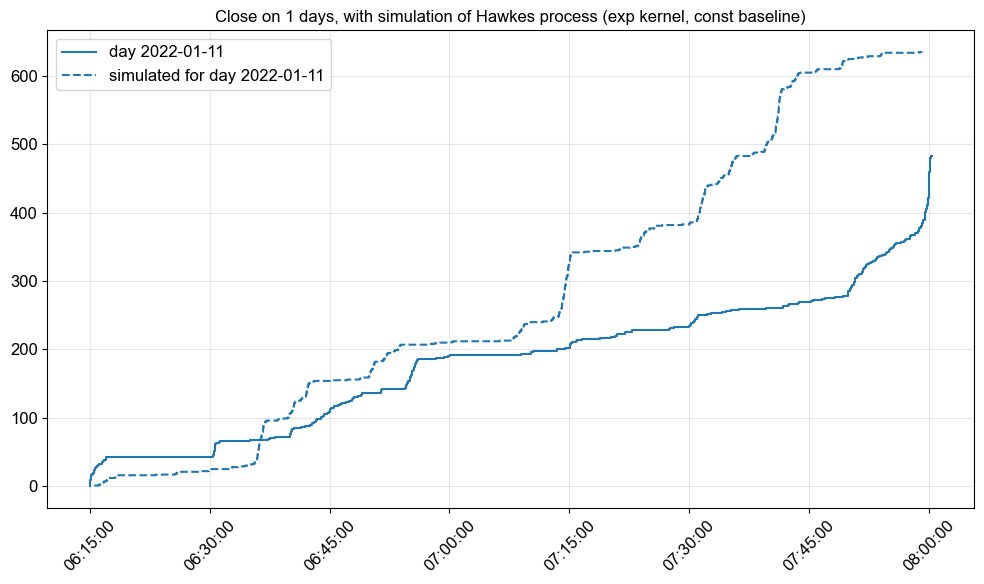

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd

# Fonction pour simuler un processus de Hawkes avec noyau exponentiel
def data_simulateur_exp(param, maximum_t):
    """
    Simulate a Hawkes process with an exp kernel.
    """
    simulateur = hk.simulator()
    simulateur.set_kernel('exp').set_baseline('const').set_parameter(param)
    interval = [0, maximum_t]
    t_simul = simulateur.simulate(interval)
    N_simul = list(range(len(t_simul)))  # Each event gets a unique index
    return t_simul, N_simul

# Fonction d'estimation des paramètres du modèle Hawkes
def estimateur_exp(tableau):
    """
    Estimate the parameters of a Hawkes process using the exponential kernel.
    """
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    
    # Vérification si le nombre d'événements est suffisant
    if len(t) < 5:
        print("Insufficient data for parameter estimation")
        return None, None
    
    model = hk.estimator().set_kernel('exp').set_baseline('const')
    
    try:
        model.fit(t, [0, np.max(t)])  # Fit the model on the time series
    except Exception as e:
        print(f"Error during model fitting: {e}")
        return None, None
    
    return model, max(t)

# Boucle principale pour simuler et afficher les résultats pour plusieurs jours
n = 1

# Choisir 1 jour aléatoire pour la simulation
jours = np.random.choice(df.timestamp.dt.date.unique(), n)  # Choisir 1 jour
colors = plt.cm.tab10(np.linspace(0, 1, n))  # Créer une palette de couleurs pour chaque jour
plt.figure(figsize=(10, 6))

for i, jour in enumerate(jours):
    # Filtrer les données pour le jour spécifié
    tableau = df[df.timestamp.dt.date == jour]  
    tabclose = tableau[tableau.isopen == 1]  # Filtrer les événements fermés (isopen == 0)
    print(jour)
    
    # Vérifier qu'il y a suffisamment de données
    if len(tabclose) < 5:
        print(f"Not enough data for day {jour}, skipping...")
        continue
    
    # Extraire les heures pour l'affichage
    times = tabclose.timestamp.dt.time
    plot_times = pd.to_datetime([f'1900-01-01 {t}' for t in times.astype(str)])
    
    # Tracer les données réelles (données réelles) avec une ligne solide et une couleur cohérente
    plt.step(plot_times, y=tabclose.N, label=f"day {jour}", color=colors[i], linestyle='-')
    
    # Obtenir les données simulées du modèle de processus Hawkes
    model, max_t = estimateur_exp(tabclose)
    
    if model is None:
        print(f"Skipping simulation for day {jour} due to estimation failure.")
        continue
    
    print("Model parameters:", model.parameter)
    print("log-likelihood:", model.L)
    print("AIC:", model.AIC)
    
    # Simuler les données en utilisant les paramètres estimés
    t_simul, N_simul = data_simulateur_exp(model.parameter, max_t)
    
    # Convertir les temps simulés (en heures) en objets datetime avec les décalages appropriés
    base_time = tabclose.timestamp.iloc[0]  # Utiliser le premier horodatage réel de la journée comme base
    simul_datetimes = [base_time + pd.Timedelta(hours=t) for t in t_simul]
    
    # Ajuster les temps simulés pour commencer à la même heure
    simul_plot_times = pd.to_datetime([f'1900-01-01 {t.time()}' for t in simul_datetimes])
    
    # Tracer les données simulées avec une ligne pointillée (dashed)
    plt.step(simul_plot_times, N_simul, label=f'simulated for day {jour}', color=colors[i], linestyle='--')

# Titre du graphique et formatage de l'axe des X
plt.title(f"Close on {n} days, with simulation of Hawkes process (exp kernel, const baseline)")
hh_mm = DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_formatter(hh_mm)  # Format de l'axe des X pour afficher l'heure
plt.grid(True, alpha=0.3)  # Ajouter la grille
plt.xticks(rotation=45)  # Faire pivoter les labels de l'axe X pour une meilleure visibilité
plt.legend()  # Afficher la légende
plt.tight_layout()  # Ajuster la mise en page pour éviter le découpage
plt.show()


{'mu': array([1385.69114307,  622.60992733, 1535.2001742 ,  634.06495705,
         52.06441903,  108.92707778,  137.89384118,  208.37749372,
        192.71382454, 2477.63615251]), 'alpha': 0.0005582285020792045, 'beta': 4.3182326586472676e-05}
log-vraisemblance: 6195.307403410665
AIC: -12384.61480682133


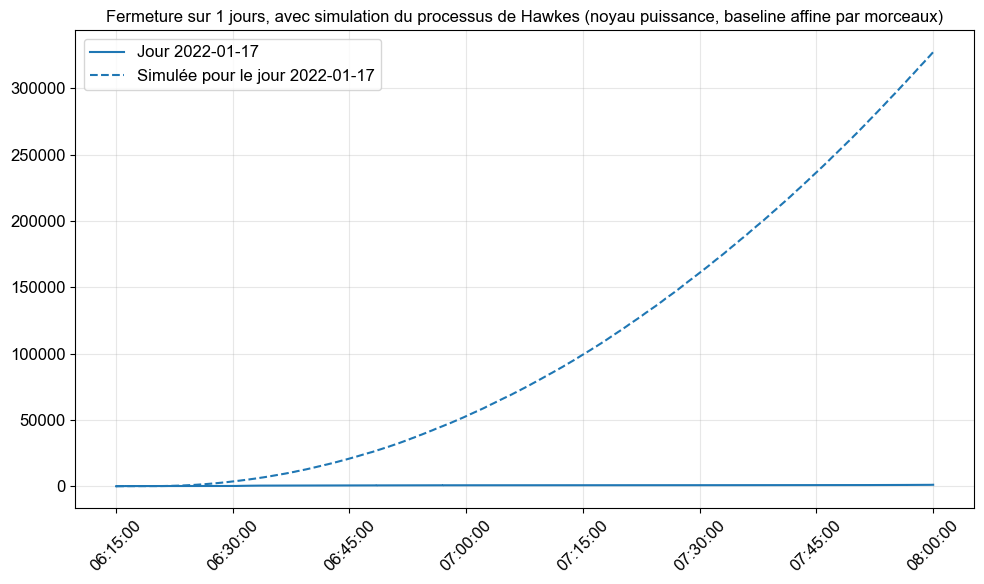

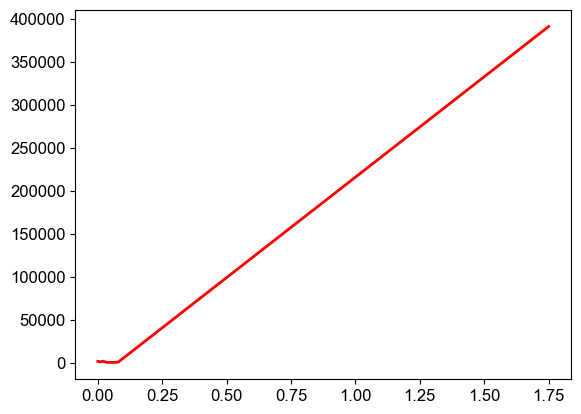

In [70]:
#Simulateur affine par morceaux qui marche pour les enchères d'ouverture

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


# Définir la fonction mu_t qui représente une baseline affine par morceaux
def build_mu_t(mu_values, x, num_points=10,l=max_t):
    """
    Fonction mu_t qui définit une baseline affine par morceaux en fonction des valeurs de mu.
    :param mu_values: Liste des valeurs de la baseline à chaque point de segmentation.
    :param x: Temps pour lequel la baseline est évaluée.
    :param num_points: Nombre de points définis dans mu_values.
    :return: Valeur de la baseline à un instant donné x.
    """
    # Identifier quel segment de la fonction affine par morceaux correspond à x
    segment_length = l / (num_points - 1)
    index = int(x // segment_length)
    
    if index >= num_points - 1:  # Si x est au dernier segment
        index = num_points - 2
    
    # Interpolation affine pour déterminer la valeur de mu_t sur le segment
    x1 = index * segment_length
    x2 = (index + 1) * segment_length
    mu1 = mu_values[index]
    mu2 = mu_values[index + 1]
    
    value = mu1 + (mu2 - mu1) * (x - x1) / (x2 - x1)
    return value  # Empêche mu(t) d'être trop proche de zéro



# Fonction de simulation avec la baseline affine par morceaux
def data_simulateur_plinear(param, maximum_t):
    """
    Simulate a Hawkes process with a power law kernel and a custom piecewise affine baseline.
    """
    simulateur = hk.simulator()
    
    # Utiliser la fonction mu_t pour la baseline personnalisée
    simulateur.set_kernel('exp').set_baseline('custom', l_custom=lambda x: build_mu_t(param['mu'], x)).set_parameter(param)
    interval = [0, maximum_t]
    t_simul = simulateur.simulate(interval)
    N_simul = list(range(len(t_simul)))  # Chaque événement obtient un index unique
    return t_simul, N_simul


def estimateur_plinear(tableau, num_points=10):
    """
    Estimate the parameters of a Hawkes process using the power law kernel and 'plinear' baseline.
    """
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('exp').set_baseline('plinear',num_basis=num_points)  # Utilisation de la baseline constante pour l'estimation
    model.fit(t, [0, np.max(t)])  # Ajuster le modèle sur la série temporelle
    return model, np.max(t)

def compare_likelihoods(df, num_points_values):
    likelihoods = []  # Liste pour stocker les log-vraisemblances
    
    for num_points in num_points_values:
        # Modifier le modèle avec le nombre de points pour la baseline
        model, max_t = estimateur_plinear(df, num_points)
        
        # Calculer la log-vraisemblance pour ce modèle
        print(f"Log-vraisemblance pour num_points={num_points}: {model.L}")
        likelihoods.append(model.L)
    
    # Retourner les log-vraisemblances pour chaque num_points
    return likelihoods


# Main loop to simulate and plot the results for multiple days
n = 1
jours = np.random.choice(df.timestamp.dt.date.unique(), n)  # Choisir des jours aléatoires
colors = plt.cm.tab10(np.linspace(0, 1, n))  # Palette de couleurs pour chaque jour
plt.figure(figsize=(10, 6))

for i, jour in enumerate(jours):
    tableau = df[df.timestamp.dt.date == jour]  # Filtrer les données pour un jour spécifique
    tabclose = tableau[tableau.isopen == 1]  # Filtrer les événements fermés (isopen == 0)
    
    # Extraire les horaires pour l'affichage
    times = tabclose.timestamp.dt.time
    plot_times = pd.to_datetime([f'1900-01-01 {t}' for t in times.astype(str)])
    
    # Tracer les données réelles (données réelles) avec une ligne continue et une couleur cohérente
    plt.step(plot_times, y=tabclose.N, label=f"Jour {jour}", color=colors[i], linestyle='-')
    
    # Obtenir les données simulées à partir de l'estimateur de processus de Hawkes
    model, max_t = estimateur_plinear(tabclose)
    print(model.parameter)
    print("log-vraisemblance:", model.L)  # Log-vraisemblance des paramètres estimés
    print("AIC:", model.AIC)  # AIC des paramètres estimés

    t_simul, N_simul = data_simulateur_plinear(model.parameter, max_t)

    
    # Convertir les temps simulés (en heures) en objets datetime avec les bons décalages horaires
    base_time = tabclose.timestamp.iloc[0]  # Utiliser le premier timestamp du jour comme base
    simul_datetimes = [base_time + pd.Timedelta(hours=t) for t in t_simul]
    
    # Ajuster les temps simulés pour commencer à la même heure et afficher la même heure
    simul_plot_times = pd.to_datetime([f'1900-01-01 {t.time()}' for t in simul_datetimes])
    
    # Tracer les données simulées avec une ligne en pointillés (même couleur que les données réelles)
    plt.step(simul_plot_times, N_simul, label=f'Simulée pour le jour {jour}', color=colors[i], linestyle='--')



# Définir le titre et les étiquettes du graphique
plt.title(f"Fermeture sur {n} jours, avec simulation du processus de Hawkes (noyau puissance, baseline affine par morceaux)")
hh_mm = DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_formatter(hh_mm)  # Formater l'axe des x pour l'heure
plt.grid(True, alpha=0.3)  # Ajouter une grille
plt.xticks(rotation=45)  # Rotation des étiquettes de l'axe des x pour une meilleure visibilité
plt.legend()  # Afficher la légende
plt.tight_layout()  # Ajuster la disposition pour éviter le chevauchement
plt.show()

#Afficher la fonction mu_t
x_values = np.linspace(0,max_t, 1000)  # Plage de temps pour évaluer mu_t
y_values = [build_mu_t(model.parameter['mu'], x) for x in x_values]  # Calculer mu_t pour chaque x

# Tracer mu_t sur le même graphique
plt.plot(x_values, y_values, label="Baseline affine par morceaux (mu_t)", color='red', linestyle='-', linewidth=2)







Log-vraisemblance pour num_points=10: 3668.015687931287


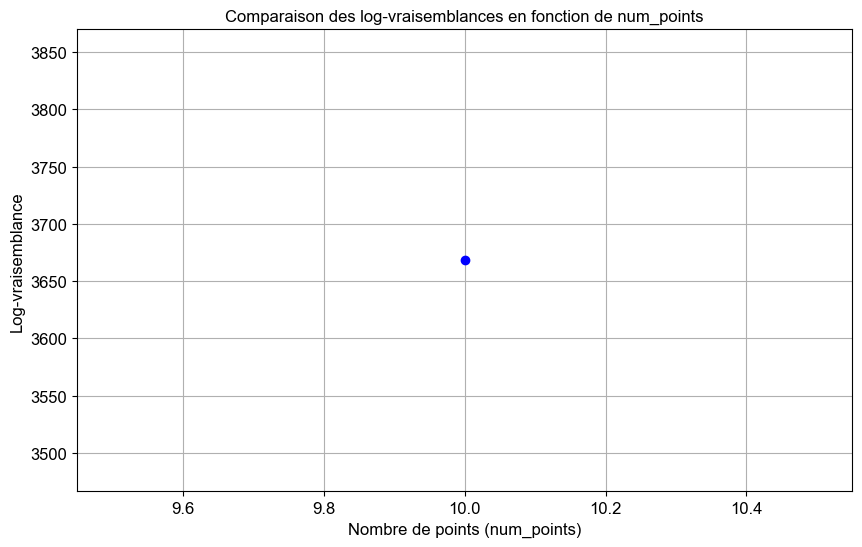

In [51]:
# Comparer la log-vraisemblance pour différentes valeurs de num_points
num_points_values = [10]  # Valeurs de num_points à tester
likelihoods = compare_likelihoods(tabclose, num_points_values)

# Tracer les log-vraisemblances en fonction de num_points
plt.figure(figsize=(10, 6))
plt.plot(num_points_values, likelihoods, marker='o', color='b', linestyle='-')
plt.title("Comparaison des log-vraisemblances en fonction de num_points")
plt.xlabel("Nombre de points (num_points)")
plt.ylabel("Log-vraisemblance")
plt.grid(True)
plt.show()

Traitement des données pour le jour 2022-01-03
Traitement des données pour le jour 2022-01-04
Traitement des données pour le jour 2022-01-05
Traitement des données pour le jour 2022-01-06
Traitement des données pour le jour 2022-01-07
Traitement des données pour le jour 2022-01-10
Traitement des données pour le jour 2022-01-11
Traitement des données pour le jour 2022-01-12
Traitement des données pour le jour 2022-01-13
Traitement des données pour le jour 2022-01-14
Traitement des données pour le jour 2022-01-17
Traitement des données pour le jour 2022-01-18
Traitement des données pour le jour 2022-01-19
Traitement des données pour le jour 2022-01-20
Traitement des données pour le jour 2022-01-21
Traitement des données pour le jour 2022-01-24
Traitement des données pour le jour 2022-01-25
Traitement des données pour le jour 2022-01-26
Traitement des données pour le jour 2022-01-27
Traitement des données pour le jour 2022-01-28
Traitement des données pour le jour 2022-01-31


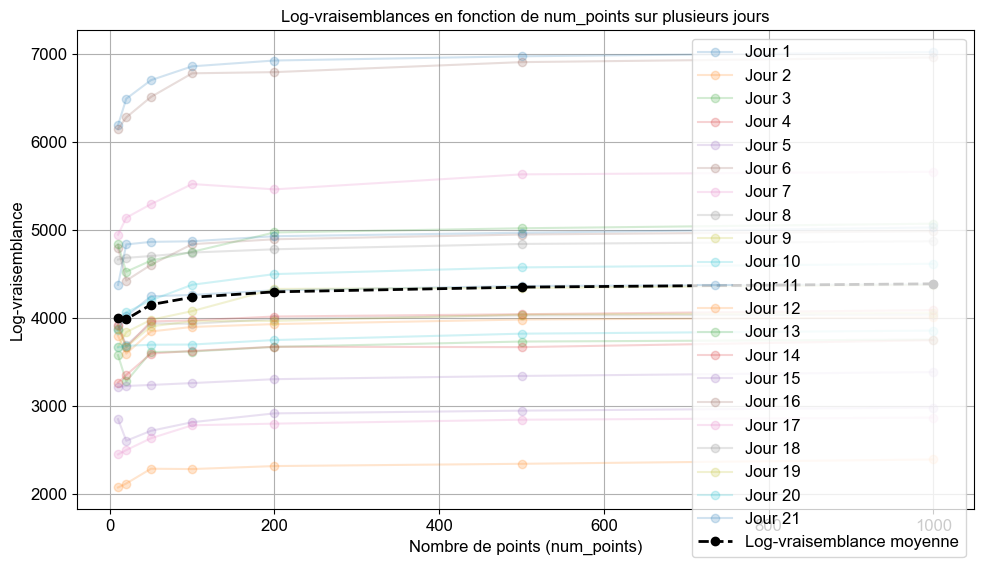

In [76]:


def estimateur_plinear(tableau, num_points=10):
    """
    Estimate the parameters of a Hawkes process using the power law kernel and 'plinear' baseline.
    """
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('exp').set_baseline('plinear',num_basis=num_points)  # Utilisation de la baseline constante pour l'estimation
    model.fit(t, [0, np.max(t)])  # Ajuster le modèle sur la série temporelle
    return model, np.max(t)



# Fonction pour estimer la log-vraisemblance pour différentes valeurs de num_points
def compare_likelihoods_for_multiple_days(df, num_points_values):
    likelihoods_by_day = []  # Liste pour stocker les log-vraisemblances par jour

    # Choisir plusieurs jours uniques
    jours_uniques = df.timestamp.dt.date.unique()
    jours_selectionnes = jours_uniques[:21]

    for i, jour in enumerate(jours_selectionnes):
        print(f"Traitement des données pour le jour {jour}")
        tableau = df[df.timestamp.dt.date == jour]  # Filtrer les données pour ce jour spécifique
        tabclose = tableau[tableau.isopen == 1]  # Filtrer les événements fermés (isopen == 1)
        likelihoods_for_day = []  # Liste pour stocker les log-vraisemblances du jour pour différentes valeurs de num_points
            
        # Calculer les log-vraisemblances pour chaque valeur de num_points pour ce jour
        for num_points in num_points_values:
            model, max_t = estimateur_plinear(tabclose, num_points)
            likelihoods_for_day.append(model.L)
            
        # Ajouter les log-vraisemblances du jour à la liste principale
        likelihoods_by_day.append(likelihoods_for_day)
    
    # Convertir la liste des log-vraisemblances en un array numpy pour calculer les moyennes
    likelihoods_by_day = np.array(likelihoods_by_day)
        
    # Calculer la moyenne des log-vraisemblances pour chaque valeur de num_points
    average_likelihoods = np.mean(likelihoods_by_day, axis=0)
        
    return likelihoods_by_day, average_likelihoods


# Valeurs de num_points à tester
num_points_values = [10, 20, 50, 100, 200, 500, 1000]

# Comparer les log-vraisemblances sur plusieurs jours
likelihoods_by_day, average_likelihoods = compare_likelihoods_for_multiple_days(df, num_points_values)

# Tracer les log-vraisemblances par jour et la moyenne
plt.figure(figsize=(10, 6))

# Tracer les log-vraisemblances de chaque jour (avec une opacité réduite)
for i, likelihoods_for_day in enumerate(likelihoods_by_day):
    plt.plot(num_points_values, likelihoods_for_day, marker='o', linestyle='-', alpha=0.2, label=f"Jour {i+1}")  # Réduire l'opacité avec alpha

# Tracer la log-vraisemblance moyenne (plus visible)
plt.plot(num_points_values, average_likelihoods, marker='o', color='black', linestyle='--', linewidth=2, label="Log-vraisemblance moyenne")

# Titre et labels
plt.title("Log-vraisemblances en fonction de num_points sur plusieurs jours")
plt.xlabel("Nombre de points (num_points)")
plt.ylabel("Log-vraisemblance")
plt.grid(True)

# Légende
plt.legend()
plt.tight_layout()

# Affichage
plt.show()


Traitement des données pour le jour 2022-01-03
Traitement des données pour le jour 2022-01-04
Traitement des données pour le jour 2022-01-05
Traitement des données pour le jour 2022-01-06
Traitement des données pour le jour 2022-01-07
Traitement des données pour le jour 2022-01-10
Traitement des données pour le jour 2022-01-11
Traitement des données pour le jour 2022-01-12
Traitement des données pour le jour 2022-01-13
Traitement des données pour le jour 2022-01-14
Traitement des données pour le jour 2022-01-17
Traitement des données pour le jour 2022-01-18
Traitement des données pour le jour 2022-01-19
Traitement des données pour le jour 2022-01-20
Traitement des données pour le jour 2022-01-21
Traitement des données pour le jour 2022-01-24
Traitement des données pour le jour 2022-01-25
Traitement des données pour le jour 2022-01-26
Traitement des données pour le jour 2022-01-27
Traitement des données pour le jour 2022-01-28
Traitement des données pour le jour 2022-01-31


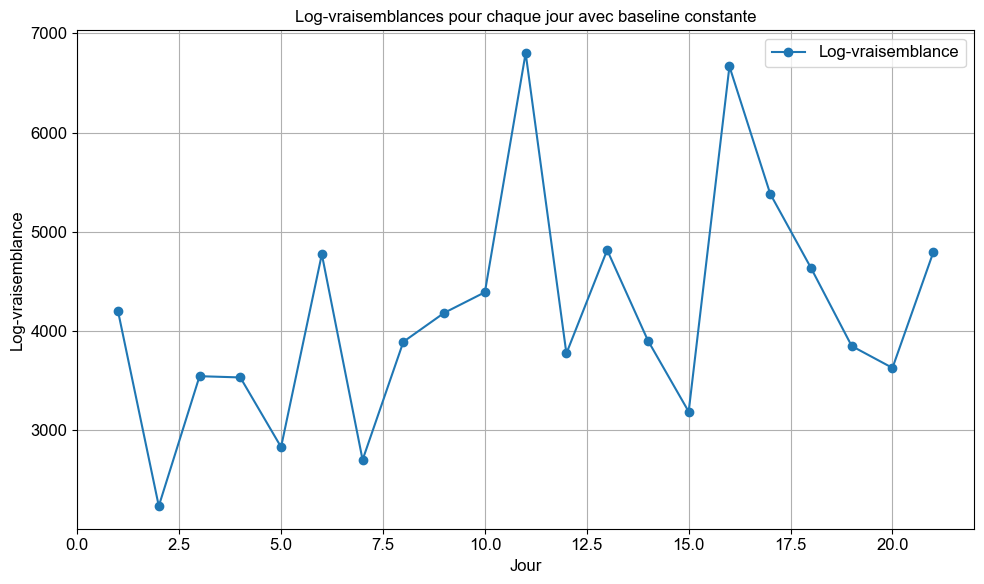


Log-vraisemblance moyenne avec baseline constante : 4177.51


In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# Convertir tous les RuntimeWarning (ex: overflow) en erreurs bloquantes
warnings.filterwarnings("error", category=RuntimeWarning)

# === Fonction pour estimer les paramètres avec baseline constante ===


def compare_likelihoods_with_const_baseline(df):
    likelihoods_by_day = []  # Liste pour stocker les log-vraisemblances par jour

    # Sélectionner quelques jours uniques pour tester
    jours_uniques = df.timestamp.dt.date.unique()
    jours_selectionnes = jours_uniques[:21]  # Par exemple, on prend les 21 premiers jours

    for i, jour in enumerate(jours_selectionnes):
        print(f"Traitement des données pour le jour {jour}")
        tableau = df[df.timestamp.dt.date == jour]  # Filtrer les données pour ce jour spécifique
        tabclose = tableau[tableau.isopen == 1]  # Filtrer les événements fermés (isopen == 1)
        
        # Calculer les log-vraisemblances pour ce jour avec baseline constante
        model, _ = estimateur_exp(tabclose)
        likelihoods_by_day.append(model.L)

    return likelihoods_by_day

# === Comparaison des log-vraisemblances pour une baseline constante ===

# Comparer les log-vraisemblances sur plusieurs jours avec baseline constante
likelihoods_by_day = compare_likelihoods_with_const_baseline(df)

# Tracer les log-vraisemblances par jour
plt.figure(figsize=(10, 6))

# Tracer les log-vraisemblances de chaque jour
plt.plot(range(1, len(likelihoods_by_day) + 1), likelihoods_by_day, marker='o', linestyle='-', label="Log-vraisemblance")

# Titre et labels
plt.title("Log-vraisemblances pour chaque jour avec baseline constante")
plt.xlabel("Jour")
plt.ylabel("Log-vraisemblance")
plt.grid(True)

# Légende
plt.legend()
plt.tight_layout()

# Affichage
plt.show()

# Calcul de la log-vraisemblance moyenne
mean_likelihood = np.mean(likelihoods_by_day)

# Affichage de la log-vraisemblance moyenne
print(f"\nLog-vraisemblance moyenne avec baseline constante : {mean_likelihood:.2f}")


In [ ]:
print(average_likelihoods)

Nombre de jours sélectionnés : 20
Jour2022-01-03 est prime
Jour2022-01-04 est prime
Jour2022-01-05 est prime
Jour2022-01-06 est prime
Jour2022-01-07 est prime
⏩ Skip jour 2022-01-10 (dans days_failed)
Jour2022-01-11 est prime
⏩ Skip jour 2022-01-12 (dans days_failed)
Jour2022-01-13 est prime
Jour2022-01-14 est prime
⏩ Skip jour 2022-01-17 (dans days_failed)
⏩ Skip jour 2022-01-18 (dans days_failed)
Jour2022-01-19 est prime
Jour2022-01-20 est prime
⏩ Skip jour 2022-01-21 (dans days_failed)
⏩ Skip jour 2022-01-24 (dans days_failed)
Jour2022-01-25 est prime
Jour2022-01-26 est prime
⏩ Skip jour 2022-01-27 (dans days_failed)
Jour2022-01-28 est prime


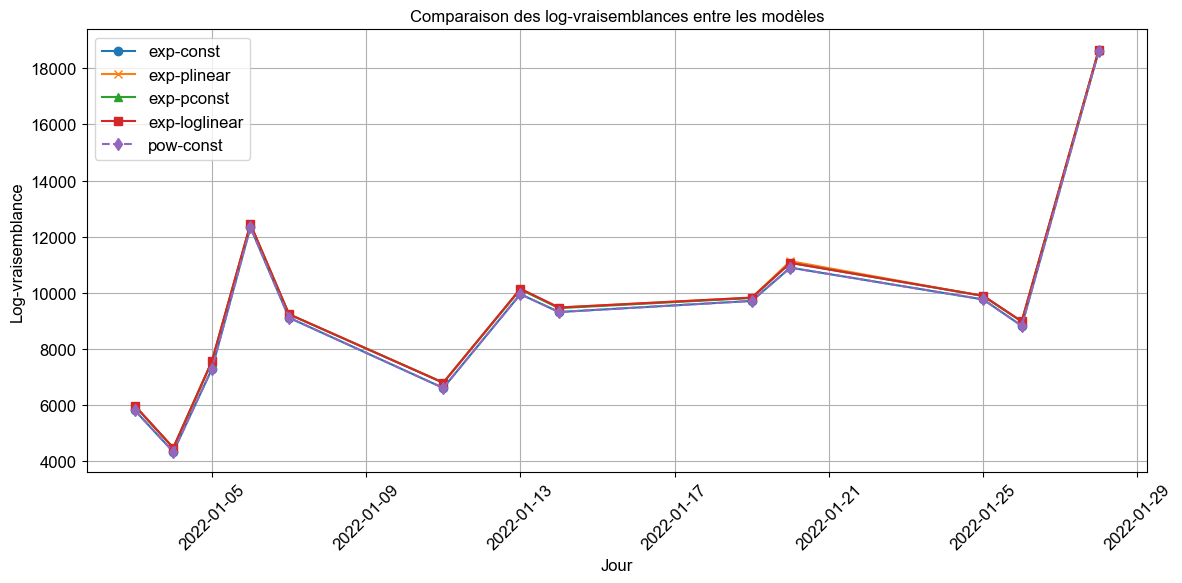

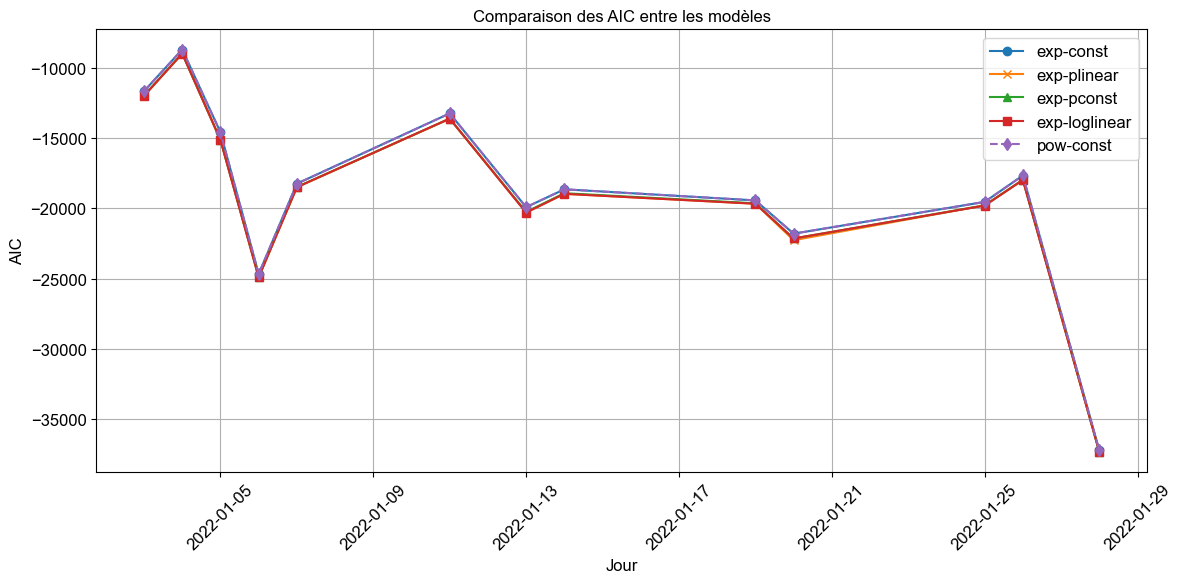


=== Moyennes des log-vraisemblances ===
exp           : 9433.94
plinear       : 9588.62
pconst        : 9578.50
loglinear     : 9587.68
pow           : 9433.94

📈 Meilleur modèle (log-vraisemblance) : plinear

=== Moyennes des AIC ===
exp           : -18861.88
plinear       : -19171.24
pconst        : -19151.00
loglinear     : -19169.35
pow           : -18859.88

✅ Meilleur modèle (AIC) : plinear


In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Initialiser les listes pour stocker les log-vraisemblances et AIC
log_likelihood_exp = []  # baseline constante (exp)
log_likelihood_plinear = []  # baseline affine par morceaux
log_likelihood_constmorceaux = []  # baseline constante par morceaux
log_likelihood_loglinear = [] #baseline loglinear
log_likelihood_pow = []
log_likelihood_pow_plinear = []
log_likelihood_pow_pconst = []
log_likelihood_pow_loglinear = []



AIC_exp = []
AIC_plinear = []
AIC_constmorceaux = []
AIC_loglinear = []
AIC_pow = []
AIC_pow_plinear = []
AIC_pow_pconst = []
AIC_pow_loglinear = []

jours_plot=[]
# Gestion des warnings comme erreurs
warnings.filterwarnings("error", category=RuntimeWarning)


# Fonction pour estimer les paramètres du modèle avec baseline constante et noyau power law
def estimateur_exp_affinemorceaux(tableau):
    """
    Estimate the parameters of a Hawkes process using the power law kernel and 'plinear' baseline.
    """
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('exp').set_baseline('plinear', num_basis=20)  # Noyau powerlaw et baseline constante
    model.fit(t, [0, np.max(t)])  # Ajuster le modèle sur la série temporelle
    return model, np.max(t)

def estimateur_exp_constmorceaux(tableau):
    """
    Estimate the parameters of a Hawkes process using baseline constante ('pconst') and no kernel.
    """
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('exp').set_baseline('pconst', num_basis=20)  # Noyau exponentiel et baseline constante
    model.fit(t, [0, np.max(t)])  # Ajuster le modèle sur la série temporelle
    return model, np.max(t)


def estimateur_exp_loglinear(tableau, num_basis=20):
    """
    Estimate the parameters of a Hawkes process using the 'loglinear' baseline.
    """
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('exp').set_baseline('loglinear', num_basis=num_basis)  # Noyau exponentiel et baseline log-linéaire
    model.fit(t, [0, np.max(t)])  # Ajuster le modèle sur la série temporelle
    return model, np.max(t)

def estimateur_pow_plinear(tableau, num_basis=20):
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('pow').set_baseline('plinear', num_basis=num_basis)
    model.fit(t, [0, np.max(t)])
    return model, np.max(t)

def estimateur_pow_pconst(tableau, num_basis=20):
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('pow').set_baseline('pconst', num_basis=num_basis)
    model.fit(t, [0, np.max(t)])
    return model, np.max(t)

def estimateur_pow_loglinear(tableau, num_basis=20):
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('pow').set_baseline('loglinear', num_basis=num_basis)
    model.fit(t, [0, np.max(t)])
    return model, np.max(t)


#np.random.seed(42)


#jours = np.random.choice(df.timestamp.dt.date.unique(), n)  # Choisir 10 jours aléatoiresjours_plot = []


# Warnings comme erreurs


warnings.filterwarnings("error", category=RuntimeWarning)

jours_uniques = df.timestamp.dt.date.unique()
jours_selectionnes = jours_uniques[:20]
#jours_selectionnes=[pd.to_datetime('2022-01-28').date()]


print(f"Nombre de jours sélectionnés : {len(jours_selectionnes)}")

for i, jour in enumerate(jours_selectionnes):
    if jour in days_failed:
        print(f"⏩ Skip jour {jour} (dans days_failed)")
        continue

    tableau = df[df.timestamp.dt.date == jour]
    tabclose = tableau[tableau.isopen == 0]

    try:
        model_exp, _ = estimateur_exp(tabclose)
        model_plinear, _ = estimateur_exp_affinemorceaux(tabclose)
        model_constmorceaux, _ = estimateur_exp_constmorceaux(tabclose)
        model_loglinear, _ = estimateur_exp_loglinear(tabclose)
        model_pow, _ = estimateur_pow(tabclose)
        #model_pow_plinear, _ = estimateur_pow_plinear(tabclose)
        #model_pow_pconst, _ = estimateur_pow_pconst(tabclose)
        #model_pow_loglinear, _ = estimateur_pow_loglinear(tabclose)

        log_likelihood_exp.append(model_exp.L)
        log_likelihood_plinear.append(model_plinear.L)
        log_likelihood_constmorceaux.append(model_constmorceaux.L)
        log_likelihood_loglinear.append(model_loglinear.L)
        log_likelihood_pow.append(model_pow.L)
        #log_likelihood_pow_plinear.append(model_pow_plinear.L)
        #log_likelihood_pow_pconst.append(model_pow_pconst.L)
        #log_likelihood_pow_loglinear.append(model_pow_loglinear.L)

        AIC_exp.append(model_exp.AIC)
        AIC_plinear.append(model_plinear.AIC)
        AIC_constmorceaux.append(model_constmorceaux.AIC)
        AIC_loglinear.append(model_loglinear.AIC)
        AIC_pow.append(model_pow.AIC)
        #AIC_pow_plinear.append(model_pow_plinear.AIC)
        #AIC_pow_pconst.append(model_pow_pconst.AIC)
        #AIC_pow_loglinear.append(model_pow_loglinear.AIC)

        jours_plot.append(jour)
        print(f'Jour{jour} est prime')

    except Exception as e:
        print(f"⚠️ Erreur sur {jour} : {e}")
        continue

# === Tracé des log-vraisemblances ===
plt.figure(figsize=(12, 6))
plt.plot(jours_plot, log_likelihood_exp, label="exp-const", marker='o')
plt.plot(jours_plot, log_likelihood_plinear, label="exp-plinear", marker='x')
plt.plot(jours_plot, log_likelihood_constmorceaux, label="exp-pconst", marker='^')
plt.plot(jours_plot, log_likelihood_loglinear, label="exp-loglinear", marker='s')

plt.plot(jours_plot, log_likelihood_pow, label="pow-const", marker='d', linestyle='--')
#plt.plot(jours_plot, log_likelihood_pow_plinear, label="pow-plinear", marker='P', linestyle='--')
#plt.plot(jours_plot, log_likelihood_pow_pconst, label="pow-pconst", marker='X', linestyle='--')
#plt.plot(jours_plot, log_likelihood_pow_loglinear, label="pow-loglinear", marker='v', linestyle='--')

plt.title("Comparaison des log-vraisemblances entre les modèles")
plt.xlabel("Jour")
plt.ylabel("Log-vraisemblance")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Tracé des AIC ===
plt.figure(figsize=(12, 6))
plt.plot(jours_plot, AIC_exp, label="exp-const", marker='o')
plt.plot(jours_plot, AIC_plinear, label="exp-plinear", marker='x')
plt.plot(jours_plot, AIC_constmorceaux, label="exp-pconst", marker='^')
plt.plot(jours_plot, AIC_loglinear, label="exp-loglinear", marker='s')

plt.plot(jours_plot, AIC_pow, label="pow-const", marker='d', linestyle='--')
#plt.plot(jours_plot, AIC_pow_plinear, label="pow-plinear", marker='P', linestyle='--')
#plt.plot(jours_plot, AIC_pow_pconst, label="pow-pconst", marker='X', linestyle='--')
#plt.plot(jours_plot, AIC_pow_loglinear, label="pow-loglinear", marker='v', linestyle='--')

plt.title("Comparaison des AIC entre les modèles")
plt.xlabel("Jour")
plt.ylabel("AIC")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# === Résultats agrégés ===
moyennes_logL = {
    "exp": np.mean(log_likelihood_exp),
    "plinear": np.mean(log_likelihood_plinear),
    "pconst": np.mean(log_likelihood_constmorceaux),
    "loglinear": np.mean(log_likelihood_loglinear),
    "pow": np.mean(log_likelihood_pow),
    #"pow_plinear": np.mean(log_likelihood_pow_plinear),
    #"pow_pconst": np.mean(log_likelihood_pow_pconst),
    #"pow_loglinear": np.mean(log_likelihood_pow_loglinear)
}

moyennes_AIC = {
    "exp": np.mean(AIC_exp),
    "plinear": np.mean(AIC_plinear),
    "pconst": np.mean(AIC_constmorceaux),
    "loglinear": np.mean(AIC_loglinear),
    "pow": np.mean(AIC_pow),
    #"pow_plinear": np.mean(AIC_pow_plinear),
    #"pow_pconst": np.mean(AIC_pow_pconst),
    #"#pow_loglinear": np.mean(AIC_pow_loglinear)
}

# === Affichage moyennes ===
print("\n=== Moyennes des log-vraisemblances ===")
for k, v in moyennes_logL.items():
    print(f"{k:<14}: {v:.2f}")
print(f"\n📈 Meilleur modèle (log-vraisemblance) : {max(moyennes_logL, key=moyennes_logL.get)}")

print("\n=== Moyennes des AIC ===")
for k, v in moyennes_AIC.items():
    print(f"{k:<14}: {v:.2f}")
print(f"\n✅ Meilleur modèle (AIC) : {min(moyennes_AIC, key=moyennes_AIC.get)}")


Nombre de jours sélectionnés : 20
Jour2022-01-03 est prime
Jour2022-01-04 est prime
Jour2022-01-05 est prime
Jour2022-01-06 est prime
Jour2022-01-07 est prime
⏩ Skip jour 2022-01-10 (dans days_failed)
Jour2022-01-11 est prime
⏩ Skip jour 2022-01-12 (dans days_failed)
Jour2022-01-13 est prime
Jour2022-01-14 est prime
⏩ Skip jour 2022-01-17 (dans days_failed)
⏩ Skip jour 2022-01-18 (dans days_failed)
Jour2022-01-19 est prime
Jour2022-01-20 est prime
⏩ Skip jour 2022-01-21 (dans days_failed)
⏩ Skip jour 2022-01-24 (dans days_failed)
Jour2022-01-25 est prime
Jour2022-01-26 est prime
⏩ Skip jour 2022-01-27 (dans days_failed)
Jour2022-01-28 est prime


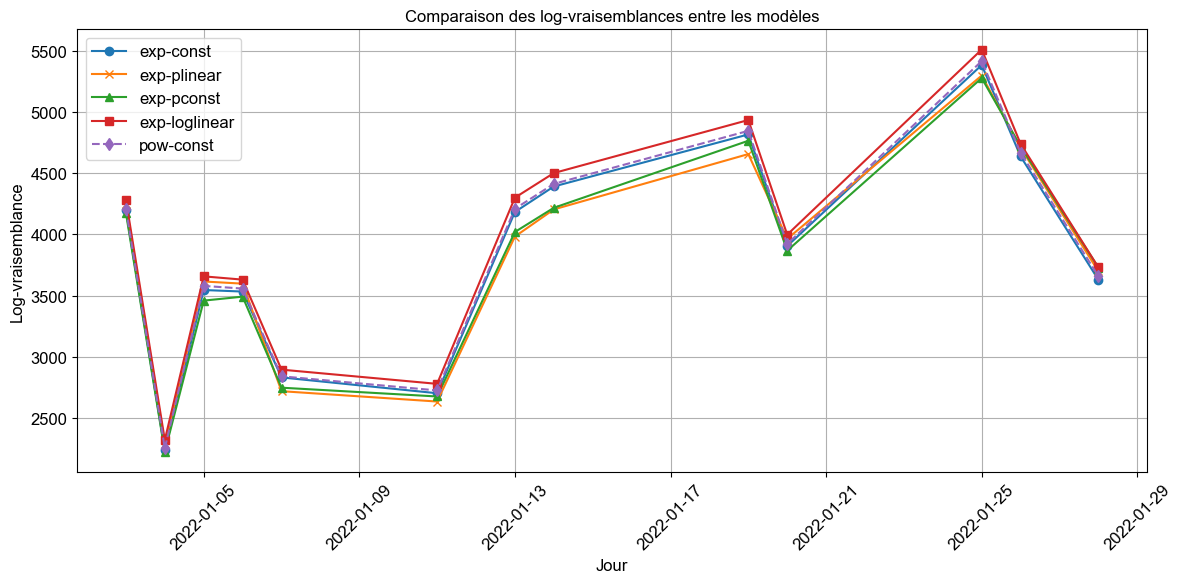

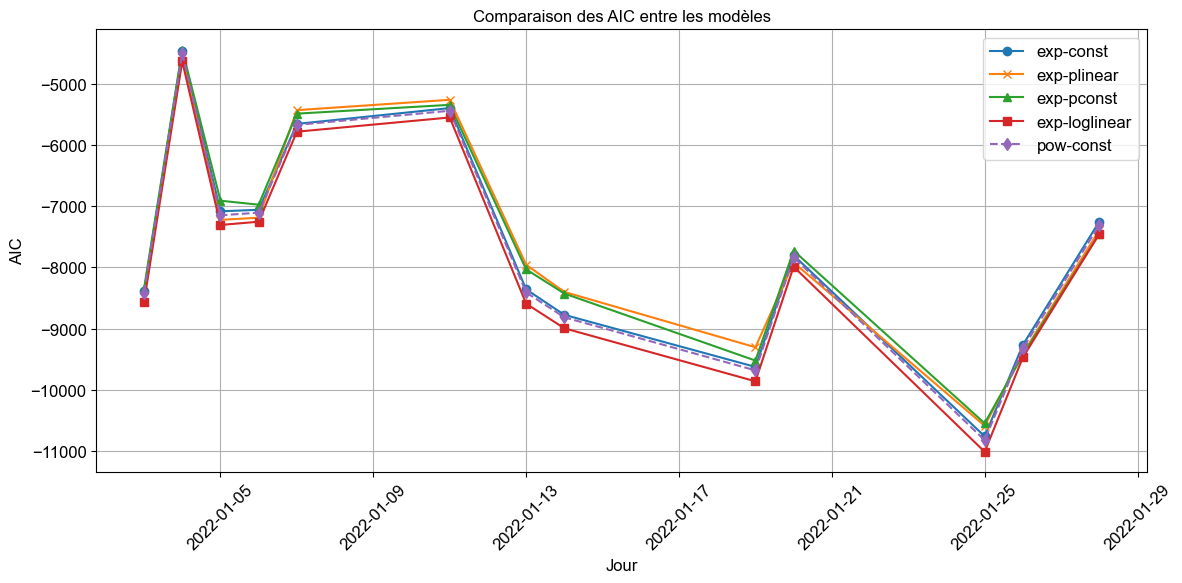


=== Moyennes des log-vraisemblances ===
exp           : 3845.57
plinear       : 3816.20
pconst        : 3797.34
loglinear     : 3944.29
pow           : 3868.64

📈 Meilleur modèle (log-vraisemblance) : loglinear

=== Moyennes des AIC ===
exp           : -7685.14
plinear       : -7626.40
pconst        : -7588.68
loglinear     : -7882.58
pow           : -7729.29

✅ Meilleur modèle (AIC) : loglinear


In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Initialiser les listes pour stocker les log-vraisemblances et AIC
log_likelihood_exp = []  # baseline constante (exp)
log_likelihood_plinear = []  # baseline affine par morceaux
log_likelihood_constmorceaux = []  # baseline constante par morceaux
log_likelihood_loglinear = [] #baseline loglinear
log_likelihood_pow = []
log_likelihood_pow_plinear = []
log_likelihood_pow_pconst = []
log_likelihood_pow_loglinear = []



AIC_exp = []
AIC_plinear = []
AIC_constmorceaux = []
AIC_loglinear = []
AIC_pow = []
AIC_pow_plinear = []
AIC_pow_pconst = []
AIC_pow_loglinear = []

jours_plot=[]
# Gestion des warnings comme erreurs
warnings.filterwarnings("error", category=RuntimeWarning)


# Fonction pour estimer les paramètres du modèle avec baseline constante et noyau power law
def estimateur_exp_affinemorceaux(tableau):
    """
    Estimate the parameters of a Hawkes process using the power law kernel and 'plinear' baseline.
    """
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('exp').set_baseline('plinear', num_basis=50)  # Noyau powerlaw et baseline constante
    model.fit(t, [0, np.max(t)])  # Ajuster le modèle sur la série temporelle
    return model, np.max(t)

def estimateur_exp_constmorceaux(tableau):
    """
    Estimate the parameters of a Hawkes process using baseline constante ('pconst') and no kernel.
    """
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('exp').set_baseline('pconst', num_basis=50)  # Noyau exponentiel et baseline constante
    model.fit(t, [0, np.max(t)])  # Ajuster le modèle sur la série temporelle
    return model, np.max(t)


def estimateur_exp_loglinear(tableau, num_basis=50):
    """
    Estimate the parameters of a Hawkes process using the 'loglinear' baseline.
    """
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('exp').set_baseline('loglinear', num_basis=num_basis)  # Noyau exponentiel et baseline log-linéaire
    model.fit(t, [0, np.max(t)])  # Ajuster le modèle sur la série temporelle
    return model, np.max(t)

def estimateur_pow_plinear(tableau, num_basis=50):
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('pow').set_baseline('plinear', num_basis=num_basis)
    model.fit(t, [0, np.max(t)])
    return model, np.max(t)

def estimateur_pow_pconst(tableau, num_basis=50):
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('pow').set_baseline('pconst', num_basis=num_basis)
    model.fit(t, [0, np.max(t)])
    return model, np.max(t)

def estimateur_pow_loglinear(tableau, num_basis=50):
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('pow').set_baseline('loglinear', num_basis=num_basis)
    model.fit(t, [0, np.max(t)])
    return model, np.max(t)


#np.random.seed(42)


#jours = np.random.choice(df.timestamp.dt.date.unique(), n)  # Choisir 10 jours aléatoiresjours_plot = []


# Warnings comme erreurs


warnings.filterwarnings("error", category=RuntimeWarning)

jours_uniques = df.timestamp.dt.date.unique()
jours_selectionnes = jours_uniques[:20]
#jours_selectionnes=[pd.to_datetime('2022-01-28').date()]


print(f"Nombre de jours sélectionnés : {len(jours_selectionnes)}")

for i, jour in enumerate(jours_selectionnes):
    if jour in days_failed:
        print(f"⏩ Skip jour {jour} (dans days_failed)")
        continue

    tableau = df[df.timestamp.dt.date == jour]
    tabclose = tableau[tableau.isopen == 1]

    try:
        model_exp, _ = estimateur_exp(tabclose)
        model_plinear, _ = estimateur_exp_affinemorceaux(tabclose)
        model_constmorceaux, _ = estimateur_exp_constmorceaux(tabclose)
        model_loglinear, _ = estimateur_exp_loglinear(tabclose)
        model_pow, _ = estimateur_pow(tabclose)
        #model_pow_plinear, _ = estimateur_pow_plinear(tabclose)
        #model_pow_pconst, _ = estimateur_pow_pconst(tabclose)
        #model_pow_loglinear, _ = estimateur_pow_loglinear(tabclose)

        log_likelihood_exp.append(model_exp.L)
        log_likelihood_plinear.append(model_plinear.L)
        log_likelihood_constmorceaux.append(model_constmorceaux.L)
        log_likelihood_loglinear.append(model_loglinear.L)
        log_likelihood_pow.append(model_pow.L)
        #log_likelihood_pow_plinear.append(model_pow_plinear.L)
        #log_likelihood_pow_pconst.append(model_pow_pconst.L)
        #log_likelihood_pow_loglinear.append(model_pow_loglinear.L)

        AIC_exp.append(model_exp.AIC)
        AIC_plinear.append(model_plinear.AIC)
        AIC_constmorceaux.append(model_constmorceaux.AIC)
        AIC_loglinear.append(model_loglinear.AIC)
        AIC_pow.append(model_pow.AIC)
        #AIC_pow_plinear.append(model_pow_plinear.AIC)
        #AIC_pow_pconst.append(model_pow_pconst.AIC)
        #AIC_pow_loglinear.append(model_pow_loglinear.AIC)

        jours_plot.append(jour)
        print(f'Jour{jour} est prime')

    except Exception as e:
        print(f"⚠️ Erreur sur {jour} : {e}")
        continue

# === Tracé des log-vraisemblances ===
plt.figure(figsize=(12, 6))
plt.plot(jours_plot, log_likelihood_exp, label="exp-const", marker='o')
plt.plot(jours_plot, log_likelihood_plinear, label="exp-plinear", marker='x')
plt.plot(jours_plot, log_likelihood_constmorceaux, label="exp-pconst", marker='^')
plt.plot(jours_plot, log_likelihood_loglinear, label="exp-loglinear", marker='s')

plt.plot(jours_plot, log_likelihood_pow, label="pow-const", marker='d', linestyle='--')
#plt.plot(jours_plot, log_likelihood_pow_plinear, label="pow-plinear", marker='P', linestyle='--')
#plt.plot(jours_plot, log_likelihood_pow_pconst, label="pow-pconst", marker='X', linestyle='--')
#plt.plot(jours_plot, log_likelihood_pow_loglinear, label="pow-loglinear", marker='v', linestyle='--')

plt.title("Comparaison des log-vraisemblances entre les modèles")
plt.xlabel("Jour")
plt.ylabel("Log-vraisemblance")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Tracé des AIC ===
plt.figure(figsize=(12, 6))
plt.plot(jours_plot, AIC_exp, label="exp-const", marker='o')
plt.plot(jours_plot, AIC_plinear, label="exp-plinear", marker='x')
plt.plot(jours_plot, AIC_constmorceaux, label="exp-pconst", marker='^')
plt.plot(jours_plot, AIC_loglinear, label="exp-loglinear", marker='s')

plt.plot(jours_plot, AIC_pow, label="pow-const", marker='d', linestyle='--')
#plt.plot(jours_plot, AIC_pow_plinear, label="pow-plinear", marker='P', linestyle='--')
#plt.plot(jours_plot, AIC_pow_pconst, label="pow-pconst", marker='X', linestyle='--')
#plt.plot(jours_plot, AIC_pow_loglinear, label="pow-loglinear", marker='v', linestyle='--')

plt.title("Comparaison des AIC entre les modèles")
plt.xlabel("Jour")
plt.ylabel("AIC")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# === Résultats agrégés ===
moyennes_logL = {
    "exp": np.mean(log_likelihood_exp),
    "plinear": np.mean(log_likelihood_plinear),
    "pconst": np.mean(log_likelihood_constmorceaux),
    "loglinear": np.mean(log_likelihood_loglinear),
    "pow": np.mean(log_likelihood_pow),
    #"pow_plinear": np.mean(log_likelihood_pow_plinear),
    #"pow_pconst": np.mean(log_likelihood_pow_pconst),
    #"pow_loglinear": np.mean(log_likelihood_pow_loglinear)
}

moyennes_AIC = {
    "exp": np.mean(AIC_exp),
    "plinear": np.mean(AIC_plinear),
    "pconst": np.mean(AIC_constmorceaux),
    "loglinear": np.mean(AIC_loglinear),
    "pow": np.mean(AIC_pow),
    #"pow_plinear": np.mean(AIC_pow_plinear),
    #"pow_pconst": np.mean(AIC_pow_pconst),
    #"#pow_loglinear": np.mean(AIC_pow_loglinear)
}

# === Affichage moyennes ===
print("\n=== Moyennes des log-vraisemblances ===")
for k, v in moyennes_logL.items():
    print(f"{k:<14}: {v:.2f}")
print(f"\n📈 Meilleur modèle (log-vraisemblance) : {max(moyennes_logL, key=moyennes_logL.get)}")

print("\n=== Moyennes des AIC ===")
for k, v in moyennes_AIC.items():
    print(f"{k:<14}: {v:.2f}")
print(f"\n✅ Meilleur modèle (AIC) : {min(moyennes_AIC, key=moyennes_AIC.get)}")


Nombre de jours sélectionnés : 20
Jour2022-01-03 est prime
Jour2022-01-04 est prime
⚠️ Erreur sur 2022-01-05 : overflow encountered in exp
⚠️ Erreur sur 2022-01-06 : overflow encountered in exp
⚠️ Erreur sur 2022-01-07 : overflow encountered in exp
⏩ Skip jour 2022-01-10 (dans days_failed)
Jour2022-01-11 est prime
⏩ Skip jour 2022-01-12 (dans days_failed)
⚠️ Erreur sur 2022-01-13 : overflow encountered in exp
⚠️ Erreur sur 2022-01-14 : overflow encountered in exp
⏩ Skip jour 2022-01-17 (dans days_failed)
⏩ Skip jour 2022-01-18 (dans days_failed)
Jour2022-01-19 est prime
⚠️ Erreur sur 2022-01-20 : overflow encountered in exp
⏩ Skip jour 2022-01-21 (dans days_failed)
⏩ Skip jour 2022-01-24 (dans days_failed)
Jour2022-01-25 est prime
⚠️ Erreur sur 2022-01-26 : overflow encountered in exp
⏩ Skip jour 2022-01-27 (dans days_failed)
⚠️ Erreur sur 2022-01-28 : overflow encountered in multiply


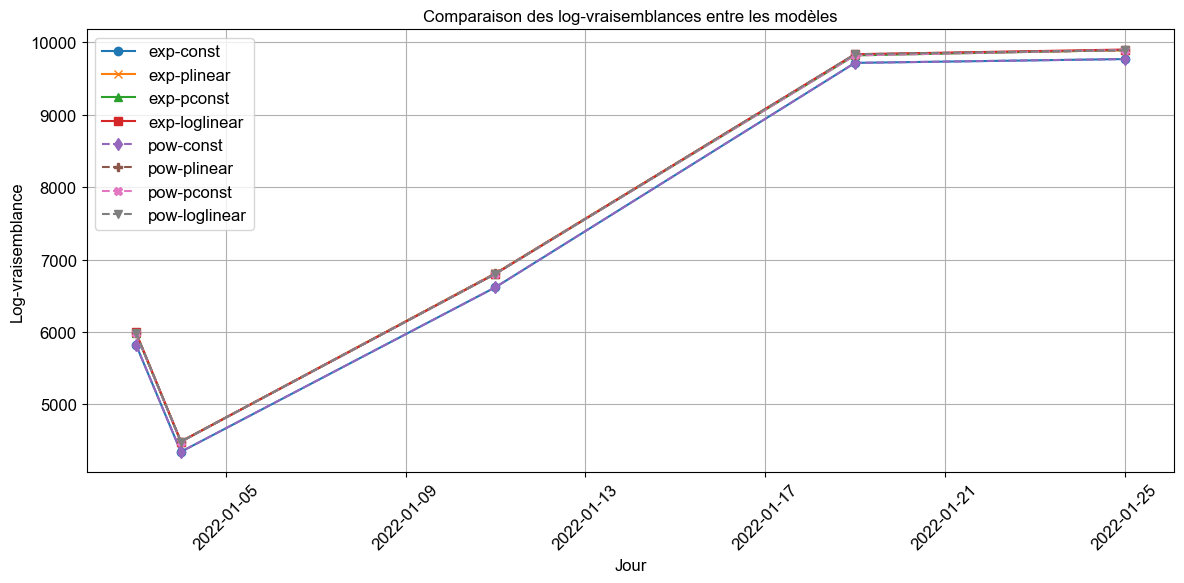

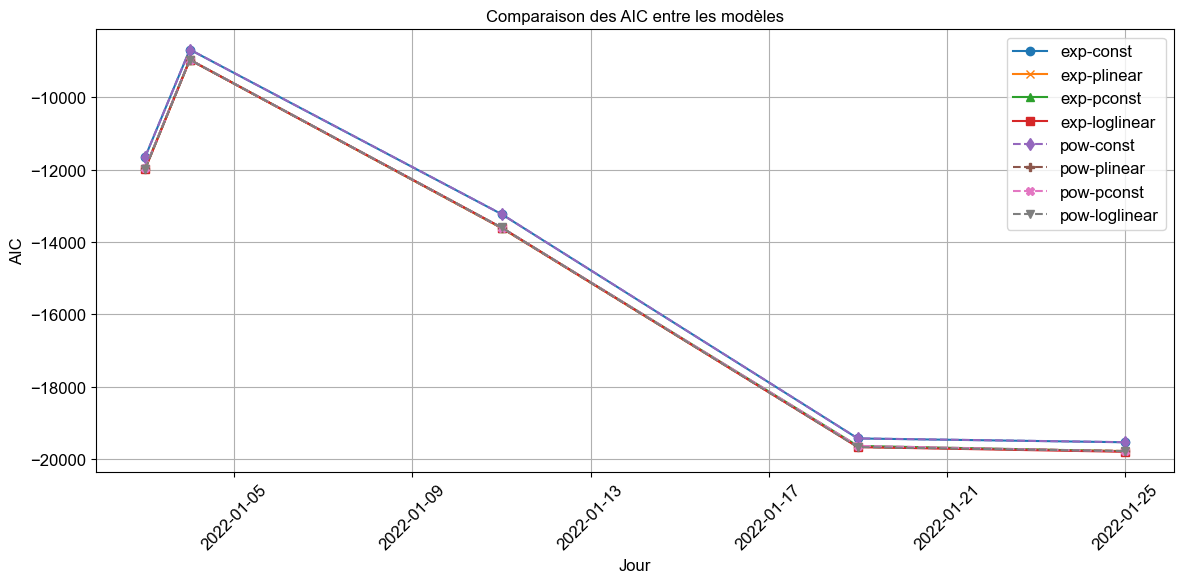


=== Moyennes des log-vraisemblances ===
exp           : 7254.30
plinear       : 7401.41
pconst        : 7396.25
loglinear     : 7403.43
pow           : 7254.30
pow_plinear   : 7401.41
pow_pconst    : 7396.25
pow_loglinear : 7401.57

📈 Meilleur modèle (log-vraisemblance) : loglinear

=== Moyennes des AIC ===
exp           : -14502.61
plinear       : -14796.82
pconst        : -14786.49
loglinear     : -14800.86
pow           : -14500.61
pow_plinear   : -14794.82
pow_pconst    : -14784.49
#pow_loglinear: -14795.15

✅ Meilleur modèle (AIC) : loglinear


In [ ]:
#Essayer sur les jours en commun


import numpy as np
import matplotlib.pyplot as plt

# Initialiser les listes pour stocker les log-vraisemblances et AIC
log_likelihood_exp = []  # baseline constante (exp)
log_likelihood_plinear = []  # baseline affine par morceaux
log_likelihood_constmorceaux = []  # baseline constante par morceaux
log_likelihood_loglinear = [] #baseline loglinear
log_likelihood_pow = []
log_likelihood_pow_plinear = []
log_likelihood_pow_pconst = []
log_likelihood_pow_loglinear = []



AIC_exp = []
AIC_plinear = []
AIC_constmorceaux = []
AIC_loglinear = []
AIC_pow = []
AIC_pow_plinear = []
AIC_pow_pconst = []
AIC_pow_loglinear = []

jours_plot=[]
# Gestion des warnings comme erreurs
warnings.filterwarnings("error", category=RuntimeWarning)


# Fonction pour estimer les paramètres du modèle avec baseline constante et noyau power law
def estimateur_exp_affinemorceaux(tableau):
    """
    Estimate the parameters of a Hawkes process using the power law kernel and 'plinear' baseline.
    """
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('exp').set_baseline('plinear', num_basis=20)  # Noyau powerlaw et baseline constante
    model.fit(t, [0, np.max(t)])  # Ajuster le modèle sur la série temporelle
    return model, np.max(t)

def estimateur_exp_constmorceaux(tableau):
    """
    Estimate the parameters of a Hawkes process using baseline constante ('pconst') and no kernel.
    """
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('exp').set_baseline('pconst', num_basis=20)  # Noyau exponentiel et baseline constante
    model.fit(t, [0, np.max(t)])  # Ajuster le modèle sur la série temporelle
    return model, np.max(t)


def estimateur_exp_loglinear(tableau, num_basis=20):
    """
    Estimate the parameters of a Hawkes process using the 'loglinear' baseline.
    """
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('exp').set_baseline('loglinear', num_basis=num_basis)  # Noyau exponentiel et baseline log-linéaire
    model.fit(t, [0, np.max(t)])  # Ajuster le modèle sur la série temporelle
    return model, np.max(t)

def estimateur_pow_plinear(tableau, num_basis=20):
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('pow').set_baseline('plinear', num_basis=num_basis)
    model.fit(t, [0, np.max(t)])
    return model, np.max(t)

def estimateur_pow_pconst(tableau, num_basis=20):
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('pow').set_baseline('pconst', num_basis=num_basis)
    model.fit(t, [0, np.max(t)])
    return model, np.max(t)

def estimateur_pow_loglinear(tableau, num_basis=20):
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('pow').set_baseline('loglinear', num_basis=num_basis)
    model.fit(t, [0, np.max(t)])
    return model, np.max(t)


#np.random.seed(42)


#jours = np.random.choice(df.timestamp.dt.date.unique(), n)  # Choisir 10 jours aléatoiresjours_plot = []


# Warnings comme erreurs


warnings.filterwarnings("error", category=RuntimeWarning)

jours_uniques = df.timestamp.dt.date.unique()
jours_selectionnes = jours_uniques[:20]
#jours_selectionnes=[pd.to_datetime('2022-01-28').date()]


print(f"Nombre de jours sélectionnés : {len(jours_selectionnes)}")

for i, jour in enumerate(jours_selectionnes):
    if jour in days_failed:
        print(f"⏩ Skip jour {jour} (dans days_failed)")
        continue

    tableau = df[df.timestamp.dt.date == jour]
    tabclose = tableau[tableau.isopen == 0]

    try:
        model_exp, _ = estimateur_exp(tabclose)
        model_plinear, _ = estimateur_exp_affinemorceaux(tabclose)
        model_constmorceaux, _ = estimateur_exp_constmorceaux(tabclose)
        model_loglinear, _ = estimateur_exp_loglinear(tabclose)
        model_pow, _ = estimateur_pow(tabclose)
        model_pow_plinear, _ = estimateur_pow_plinear(tabclose)
        model_pow_pconst, _ = estimateur_pow_pconst(tabclose)
        model_pow_loglinear, _ = estimateur_pow_loglinear(tabclose)

        log_likelihood_exp.append(model_exp.L)
        log_likelihood_plinear.append(model_plinear.L)
        log_likelihood_constmorceaux.append(model_constmorceaux.L)
        log_likelihood_loglinear.append(model_loglinear.L)
        log_likelihood_pow.append(model_pow.L)
        log_likelihood_pow_plinear.append(model_pow_plinear.L)
        log_likelihood_pow_pconst.append(model_pow_pconst.L)
        log_likelihood_pow_loglinear.append(model_pow_loglinear.L)

        AIC_exp.append(model_exp.AIC)
        AIC_plinear.append(model_plinear.AIC)
        AIC_constmorceaux.append(model_constmorceaux.AIC)
        AIC_loglinear.append(model_loglinear.AIC)
        AIC_pow.append(model_pow.AIC)
        AIC_pow_plinear.append(model_pow_plinear.AIC)
        AIC_pow_pconst.append(model_pow_pconst.AIC)
        AIC_pow_loglinear.append(model_pow_loglinear.AIC)

        jours_plot.append(jour)
        print(f'Jour{jour} est prime')

    except Exception as e:
        print(f"⚠️ Erreur sur {jour} : {e}")
        continue

# === Tracé des log-vraisemblances ===
plt.figure(figsize=(12, 6))
plt.plot(jours_plot, log_likelihood_exp, label="exp-const", marker='o')
plt.plot(jours_plot, log_likelihood_plinear, label="exp-plinear", marker='x')
plt.plot(jours_plot, log_likelihood_constmorceaux, label="exp-pconst", marker='^')
plt.plot(jours_plot, log_likelihood_loglinear, label="exp-loglinear", marker='s')

plt.plot(jours_plot, log_likelihood_pow, label="pow-const", marker='d', linestyle='--')
plt.plot(jours_plot, log_likelihood_pow_plinear, label="pow-plinear", marker='P', linestyle='--')
plt.plot(jours_plot, log_likelihood_pow_pconst, label="pow-pconst", marker='X', linestyle='--')
plt.plot(jours_plot, log_likelihood_pow_loglinear, label="pow-loglinear", marker='v', linestyle='--')

plt.title("Comparaison des log-vraisemblances entre les modèles")
plt.xlabel("Jour")
plt.ylabel("Log-vraisemblance")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Tracé des AIC ===
plt.figure(figsize=(12, 6))
plt.plot(jours_plot, AIC_exp, label="exp-const", marker='o')
plt.plot(jours_plot, AIC_plinear, label="exp-plinear", marker='x')
plt.plot(jours_plot, AIC_constmorceaux, label="exp-pconst", marker='^')
plt.plot(jours_plot, AIC_loglinear, label="exp-loglinear", marker='s')

plt.plot(jours_plot, AIC_pow, label="pow-const", marker='d', linestyle='--')
plt.plot(jours_plot, AIC_pow_plinear, label="pow-plinear", marker='P', linestyle='--')
plt.plot(jours_plot, AIC_pow_pconst, label="pow-pconst", marker='X', linestyle='--')
plt.plot(jours_plot, AIC_pow_loglinear, label="pow-loglinear", marker='v', linestyle='--')

plt.title("Comparaison des AIC entre les modèles")
plt.xlabel("Jour")
plt.ylabel("AIC")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# === Résultats agrégés ===
moyennes_logL = {
    "exp": np.mean(log_likelihood_exp),
    "plinear": np.mean(log_likelihood_plinear),
    "pconst": np.mean(log_likelihood_constmorceaux),
    "loglinear": np.mean(log_likelihood_loglinear),
    "pow": np.mean(log_likelihood_pow),
    "pow_plinear": np.mean(log_likelihood_pow_plinear),
    "pow_pconst": np.mean(log_likelihood_pow_pconst),
    "pow_loglinear": np.mean(log_likelihood_pow_loglinear)
}

moyennes_AIC = {
    "exp": np.mean(AIC_exp),
    "plinear": np.mean(AIC_plinear),
    "pconst": np.mean(AIC_constmorceaux),
    "loglinear": np.mean(AIC_loglinear),
    "pow": np.mean(AIC_pow),
    "pow_plinear": np.mean(AIC_pow_plinear),
    "pow_pconst": np.mean(AIC_pow_pconst),
    "#pow_loglinear": np.mean(AIC_pow_loglinear)
}

# === Affichage moyennes ===
print("\n=== Moyennes des log-vraisemblances ===")
for k, v in moyennes_logL.items():
    print(f"{k:<14}: {v:.2f}")
print(f"\n📈 Meilleur modèle (log-vraisemblance) : {max(moyennes_logL, key=moyennes_logL.get)}")

print("\n=== Moyennes des AIC ===")
for k, v in moyennes_AIC.items():
    print(f"{k:<14}: {v:.2f}")
print(f"\n✅ Meilleur modèle (AIC) : {min(moyennes_AIC, key=moyennes_AIC.get)}")



{'mu': 9601.621718606892, 'alpha': 0.0004514385503650588, 'beta': 6.743769849239351e-05} 0.08436074833333333


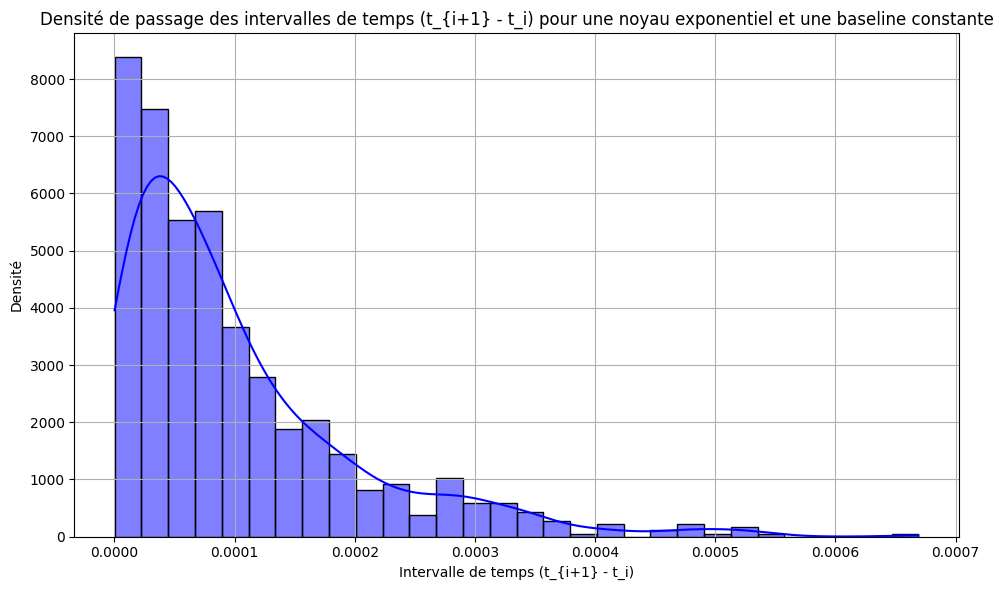

In [ ]:
#Plot la densité de passage des instants ti+1 à ti pour le modèle de Hawks: noyau exponentiel et baseline constante 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simuler un modèle de Hawkes
def data_simulateur_exp(param, maximum_t=max(t)):
    """
    Simulate a Hawkes process with an exp kernel.
    """
    simulateur = hk.simulator()
    simulateur.set_kernel('exp').set_baseline('const').set_parameter(param)
    interval = [0, maximum_t]
    t_simul = simulateur.simulate(interval)
    return t_simul

def estimateur_exp(tableau):
    """
    Estimate the parameters of a Hawkes process using the power law kernel.
    """
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('exp').set_baseline('const')  # Use power law kernel
    model.fit(t, [0, np.max(t)])  # Fit the model on the time series
    return model, max(t)



n = 1  # Choisir 10 jours pour la comparaison
jours = np.random.choice(df.timestamp.dt.date.unique(), n)  # Choisir 10 jours aléatoires


tableau = df[df.timestamp.dt.date == jour]  # Filtrer les données pour un jour spécifique
tabclose = tableau[tableau.isopen == 0]  # Filtrer les événements fermés (isopen == 0)
    
# Obtenir les données simulées avec le modèle baseline constante (exp)
model_exp, max_t = estimateur_exp(tabclose)  # Modèle avec baseline constante (exp)
print(model_exp.parameter,max_t)

t_simul = data_simulateur_exp(model_exp.parameter, max_t)
# Calcul des intervalles de temps entre les événements successifs (t_i+1 - t_i)
inter_arrival_times = np.diff(t_simul)
a   
# Tracer la densité de passage des intervalles de temps
plt.figure(figsize=(10, 6))
sns.histplot(inter_arrival_times, kde=True, bins=30, color='blue', stat='density')
plt.title("Densité de passage des intervalles de temps (t_{i+1} - t_i) pour une noyau exponentiel et une baseline constante")
plt.xlabel("Intervalle de temps (t_{i+1} - t_i)")
plt.ylabel("Densité")
plt.grid(True)
plt.tight_layout()
plt.show()


le vrai max_t 0.08436074833333333
{'mu': array([16986.03465922,  3524.1554919 ,  4172.61413881,  1883.75446315,
       12587.83341128]), 'alpha': 0.36619112571422247, 'beta': 7170.788019307263}
log-vraisemblance: 6797.916443307594
AIC: -13589.832886615188
t_simul: [0.00012925 0.00023046 0.00026686 ... 0.08422871 0.08428922 0.08434169]


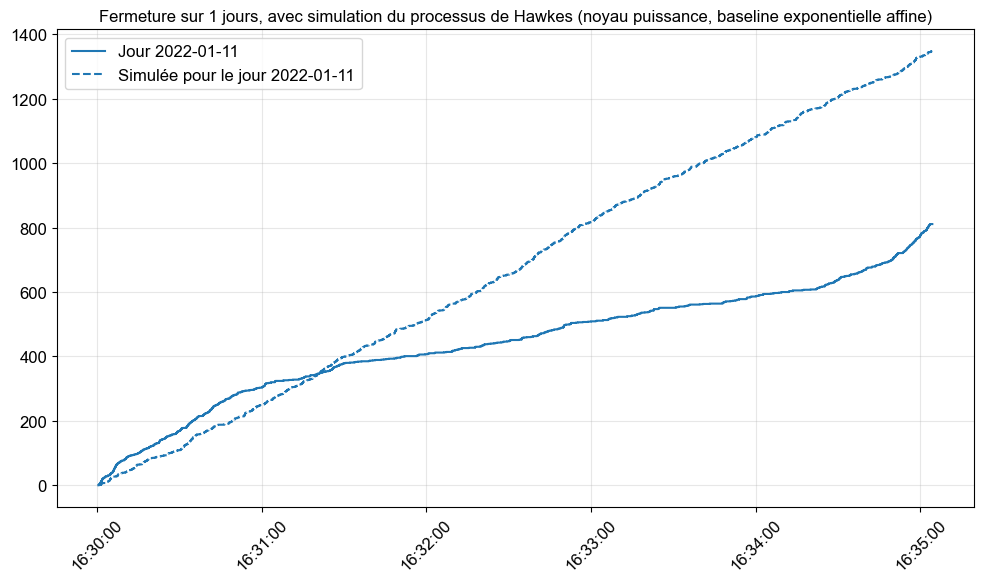

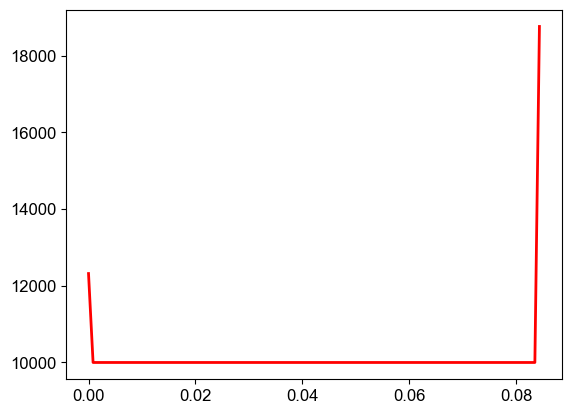

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


num_basis=5

# Définir la fonction de base f^(x) (cosine bump function)
def f_bump(x):
    """
    Fonction f^(x) : [cos(pi * x /2) + 1] / 4 pour |x| ≤ 2, 0 sinon
    :param x: Entrée
    :return: Valeur de f^(x)"""

    if x<=0.008 and x>=-0.008:
        return (np.cos((np.pi * x)/2) + 1) / 4
    else: 
        return 0



# Définir la fonction fi(x) pour i allant de 1 à num_basis
def f_i(x, i,w):
    """
    Fonction fi(x) pour la baseline. Chaque fonction fi(x) est un décalage de f^(x).
    :param x: Entrée
    :param i: Index de la fonction de base
    :param num_basis: Nombre de fonctions de base
    :param w: Largeur de la fenêtre
    :param l: Longueur de l'intervalle d'observation
    :return: Valeur de fi(x)
    """
    # Calculer la fonction fi(x) selon la formule donnée
    return f_bump((x - (i - 2) * w) / w)

# Fonction qui définit la baseline μ(t) = exp(∑ μ_i f_i(t))
def build_mu_t(mu_values, t, l,num_basis=5,max_sum=700):
    """
    Fonction qui définit une baseline de la forme :
    μ(t) = exp(Σ μ_i f_i(t))
    :param mu_values: Liste des valeurs de mu à chaque point de segmentation.
    :param t: Temps pour lequel la baseline est évaluée.
    :param num_basis: Nombre de fonctions de base (num_basis).
    :param l: Longueur de l'intervalle d'observation
    :param max_sum: Maximum autorisé pour la somme avant d'appliquer l'exponentielle
    :return: Valeur de la baseline à un instant donné t.
    """
    # Calculer la largeur w des fonctions de base
    w = l / (num_basis - 3)
    
    # Calculer la somme Σ μ_i f_i(t)
    sum_terms = 0
    for i in range(num_basis):
        sum_terms += mu_values[i] * f_i(t, i, w)
    
    # Clipper la somme pour éviter les dépassements dans exp()
    sum_terms = np.clip(sum_terms, -max_sum, max_sum)
    
    # Retourner l'exponentielle de la somme
    return np.exp(sum_terms)

# Exemple de valeurs de mu_i préfaites (petites valeurs)
mu_values_example = [0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,0.4,0.5,0.8,0.9,0.6,0.2,0.3,0.4]  # Liste de valeurs petites


# Fonction de simulation avec la baseline affine par morceaux
def data_simulateur_exp_loglinear(param, maximum_t):
    """
    Simulate a Hawkes process with a power law kernel and a custom piecewise affine baseline.
    """
    simulateur = hk.simulator()
    
    # Utiliser la fonction mu_t pour la baseline personnalisée
    simulateur.set_kernel('exp').set_baseline('custom', l_custom=lambda x: 10000*build_mu_t((model.parameter['mu'])/10000, x,maximum_t, num_basis=5)).set_parameter(param)
    interval = [0, maximum_t]
    t_simul = simulateur.simulate(interval)
    N_simul = list(range(len(t_simul)))  # Chaque événement obtient un index unique

    # Afficher les données simulées pour déboguer
    print("t_simul:", t_simul)  # Vérifier si les temps simulés sont corrects
 
    
    return t_simul, N_simul

def estimateur_exp_loglinear(tableau):
    """
    Estimate the parameters of a Hawkes process using the power law kernel and 'plinear' baseline.
    """
    t = np.sort(np.array([(x - tableau.timestamp.iloc[0]).total_seconds() / 3600 for x in tableau.timestamp]))
    model = hk.estimator().set_kernel('exp').set_baseline('plinear', num_basis=5)  # Utilisation de la baseline constante pour l'estimation
    model.fit(t, [0, np.max(t)])  # Ajuster le modèle sur la série temporelle
    return model, np.max(t)

# Main loop to simulate and plot the results for multiple days
n = 1
np.random.seed(42)
jours = np.random.choice(df.timestamp.dt.date.unique(), n)  # Choisir des jours aléatoires
colors = plt.cm.tab10(np.linspace(0, 1, n))  # Palette de couleurs pour chaque jour
plt.figure(figsize=(10, 6))

for i, jour in enumerate(jours):
    tableau = df[df.timestamp.dt.date == jour]  # Filtrer les données pour un jour spécifique
    tabclose = tableau[tableau.isopen == 0]  # Filtrer les événements fermés (isopen == 0)
    
    # Extraire les horaires pour l'affichage
    times = tabclose.timestamp.dt.time
    plot_times = pd.to_datetime([f'1900-01-01 {t}' for t in times.astype(str)])


    # Tracer les données réelles (données réelles) avec une ligne continue et une couleur cohérente
    plt.step(plot_times, y=tabclose.N, label=f"Jour {jour}", color=colors[i], linestyle='-')

    
    # Obtenir les données simulées à partir de l'estimateur de processus de Hawkes
    model, max_t = estimateur_exp_loglinear(tabclose)
    print("le vrai max_t",max_t)
    print(model.parameter)
    print("log-vraisemblance:", model.L)  # Log-vraisemblance des paramètres estimés
    print("AIC:", model.AIC)  # AIC des paramètres estimés

    t_simul, N_simul = data_simulateur_exp_loglinear(model.parameter, max_t)
    
    # Convertir les temps simulés (en heures) en objets datetime avec les bons décalages horaires
    base_time = tabclose.timestamp.iloc[0]  # Utiliser le premier timestamp du jour comme base
    simul_datetimes = [base_time + pd.Timedelta(hours=t) for t in t_simul]
    
    # Ajuster les temps simulés pour commencer à la même heure et afficher la même heure
    simul_plot_times = pd.to_datetime([f'1900-01-01 {t.time()}' for t in simul_datetimes])
    
    # Tracer les données simulées avec une ligne en pointillés (même couleur que les données réelles)
    plt.step(simul_plot_times, N_simul, label=f'Simulée pour le jour {jour}', color=colors[i], linestyle='--')



# Définir le titre et les étiquettes du graphique
plt.title(f"Fermeture sur {n} jours, avec simulation du processus de Hawkes (noyau puissance, baseline exponentielle affine)")
hh_mm = DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_formatter(hh_mm)  # Formater l'axe des x pour l'heure
plt.grid(True, alpha=0.3)  # Ajouter une grille
plt.xticks(rotation=45)  # Rotation des étiquettes de l'axe des x pour une meilleure visibilité
plt.legend()  # Afficher la légende
plt.tight_layout()  # Ajuster la disposition pour éviter le chevauchement
plt.show()


#Afficher la fonction mu_t
x_values = np.linspace(0, max_t , 100)  # Plage de temps pour évaluer mu_t
y_values = [ 10000*build_mu_t((model.parameter['mu'])/10000, x, max_t) for x in x_values]  # Calculer mu_t pour chaque x
#y_values= [f_i(x, 2, max_t/(num_basis-3)) for x in x_values]
#y_values2= [f_i(x, 3, max_t/(num_basis-3)) for x in x_values]
#y_values3=[f_bump(x) for x in x_values]

# Tracer mu_t sur le même graphique
plt.plot(x_values, y_values, label="mu_t", color='red', linestyle='-', linewidth=2)
#plt.plot(x_values,y_values2, label='fi3', color='green')
#plt.plot(x_values,y_values3, label='fbump', color='blue')


idea : {value : time max}
for t< time max:
    return value 
-> that way we can get an average of durations

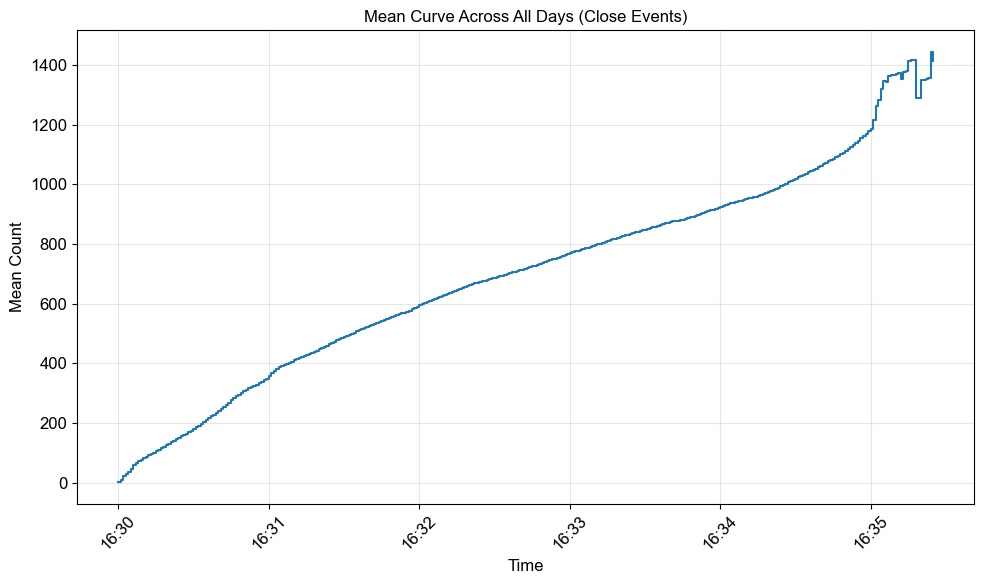

In [ ]:
def compute_mean_curve(df, isopen_value=0, freq='1s'):
    """
    Compute mean curve across different days
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with 'timestamp' and 'N' columns
    isopen_value : int
        Value to filter the isopen column (0 for close, 1 for open)
    freq : str
        Frequency for resampling (e.g., '1min', '1s')
        
    Returns:
    --------
    mean_df : pandas DataFrame
        DataFrame with binned time and mean N values
    """
    # Get unique dates
    unique_dates = df.timestamp.dt.date.unique()
    
    # Initialize a list to store resampled dataframes for each day
    resampled_dfs = []
    
    # Process each day
    for day in unique_dates:
        # Get data for this day and filter by isopen
        day_data = df[(df.timestamp.dt.date == day) & (df.isopen == isopen_value)]
        
        if len(day_data) == 0:
            continue
            
        # Convert to datetime index and set only the time component
        day_time = pd.Series(day_data.N.values,
                             index=pd.to_datetime('1900-01-01 ' + 
                                                 day_data.timestamp.dt.time.astype(str)))
        
        # Resample to get uniform time bins
        resampled = day_time.resample(freq).mean().ffill()
        resampled_dfs.append(resampled)
    
    # Combine all resampled dataframes
    all_resampled = pd.concat(resampled_dfs, axis=1)
    
    # Compute the mean across all days
    mean_curve = all_resampled.mean(axis=1).dropna()
    
    return mean_curve

# Example usage
mean_curve = compute_mean_curve(df, isopen_value=0, freq='1s')

# Plot the mean curve
plt.figure(figsize=(10, 6))
plt.step(mean_curve.index, mean_curve.values, where='post')
plt.title('Mean Curve Across All Days (Close Events)')
plt.xlabel('Time')
plt.ylabel('Mean Count')

# Format x-axis
hh_mm = DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(hh_mm)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()